In [1]:
import os
import math
import uproot
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import roc_curve

In [2]:
xgb.config_context(verbosity=3)       # debug = 3, silent = 3

In [3]:
#plt.xkcd()

## Read in input data files, merge signal and background datasets, cleaning cuts

In [4]:
Files= ["l1calo_hist_ZMUMU_merg19aug24.root","l1calo_hist_EGZ_extended.root","l1calo_hist_EGZ_extended_new.root"] # "extended" includes isolation vars and extended_new trigger decision

In [5]:
DFs = []

for i in range (0,len(Files)):
  File = uproot.open(Files[i])
  Tree = File["tree_DMC"]
  DFs.append(Tree.arrays(library="pd"))
  print (DFs[i].shape, DFs[i].columns)

(95098, 24) Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_ET', 'eFEX_PS_ET',
       'eFEX_L1_ET', 'eFEX_L2_ET', 'eFEX_L3_ET', 'legacy_ET', 'eFEX_ReC',
       'eFEX_ReE', 'eFEX_RhE', 'eFEX_RhH', 'eFEX_WsN', 'eFEX_WsD', 'ID',
       'SuperCell_ET'],
      dtype='object')
(89169, 22) Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_ET', 'eFEX_PS_ET',
       'eFEX_L1_ET', 'eFEX_L2_ET', 'eFEX_L3_ET', 'SuperCell_ET', 'eFEX_ReC',
       'eFEX_ReE', 'eFEX_RhE', 'eFEX_RhH', 'eFEX_WsN', 'eFEX_WsD'],
      dtype='object')
(89169, 17) Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_ET

In [6]:
DF_background=DFs[0]
DF_background.shape

(95098, 24)

In [7]:
DF_signal=pd.concat([DFs[1],DFs[2]['ID']],axis=1)
DF_signal.shape

(89169, 23)

In [8]:
#Add labels
DF_background['Label'] = 0  # apply labels
DF_signal['Label'] = 1

In [9]:
#Merge them
DF_background.columns

Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_ET', 'eFEX_PS_ET',
       'eFEX_L1_ET', 'eFEX_L2_ET', 'eFEX_L3_ET', 'legacy_ET', 'eFEX_ReC',
       'eFEX_ReE', 'eFEX_RhE', 'eFEX_RhH', 'eFEX_WsN', 'eFEX_WsD', 'ID',
       'SuperCell_ET', 'Label'],
      dtype='object')

In [10]:
DF_signal.columns

Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_ET', 'eFEX_PS_ET',
       'eFEX_L1_ET', 'eFEX_L2_ET', 'eFEX_L3_ET', 'SuperCell_ET', 'eFEX_ReC',
       'eFEX_ReE', 'eFEX_RhE', 'eFEX_RhH', 'eFEX_WsN', 'eFEX_WsD', 'ID',
       'Label'],
      dtype='object')

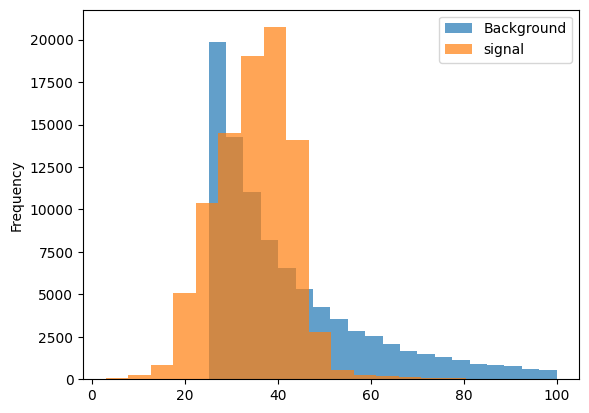

In [11]:
DF_background.query("TOB_ET < 100")["TOB_ET"].plot(kind='hist',bins=20,alpha=0.7)
DF_signal.query("TOB_ET < 100")["TOB_ET"].plot(kind='hist',bins=20,alpha=0.7)
plt.legend(["Background","signal"])
plt.savefig("TOB_pt.png")
plt.show()

In [12]:
variablesAll=['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal','eFEX_ReC',
       'eFEX_ReE', 'eFEX_RhE', 'eFEX_RhH', 'eFEX_WsN', 'eFEX_WsD', 'ID',
       'Label']       # can expand later if needed

In [13]:
DF_all=pd.concat([DF_signal[variablesAll],DF_background[variablesAll]]).reset_index(drop=True)
DF_all.shape

(184267, 16)

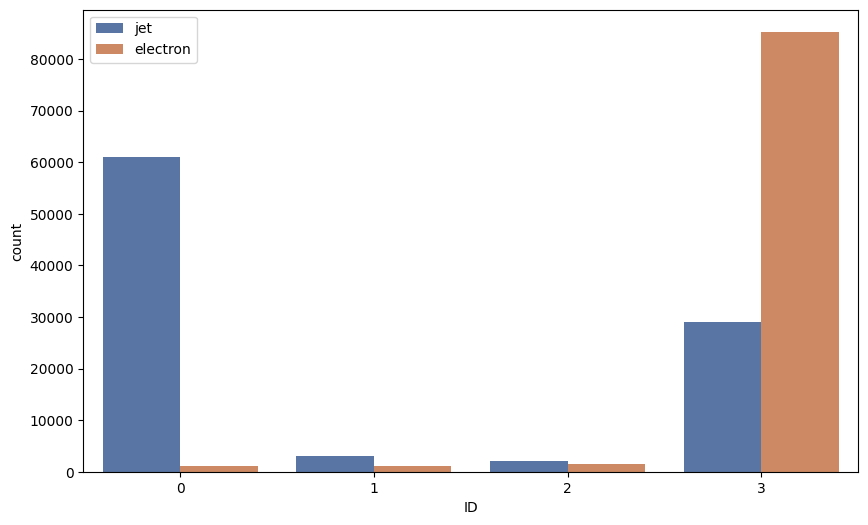

In [14]:
# Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='ID', 
                   hue='Label', 
                   data=DF_all,
                   hue_order=[0, 1],  # Specify the order if needed
                   palette='deep'    # Choose a color palette
                  )
# Customize the legend title
ax.legend(title='Particle Type')
ax.legend(["jet","electron"])
plt.show()

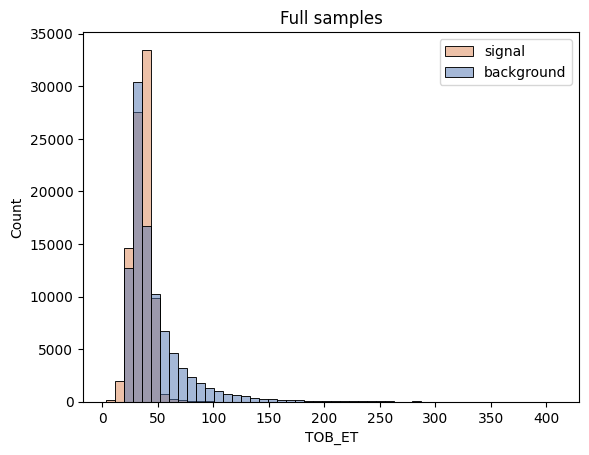

In [15]:
ax = sns.histplot( x='TOB_ET', 
                   hue='Label', 
                   data=DF_all,
                   hue_order=[0, 1],  # Specify the order if needed
                   palette='deep',    # Choose a color palette
                   #binrange=(0,100),
                   bins=50
                  )
ax.set(title="Full samples")
ax.legend(["signal","background"])

plt.show()

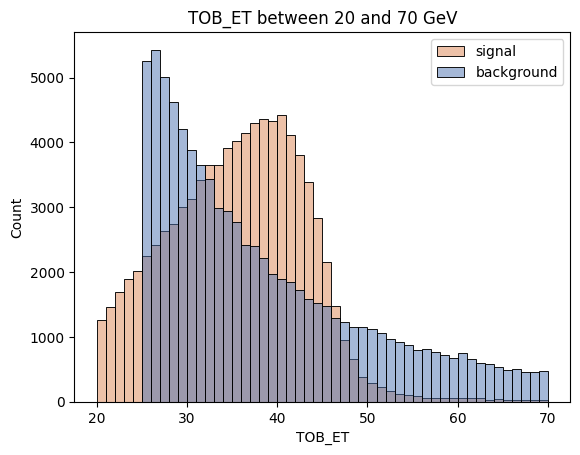

In [16]:
ax = sns.histplot( x='TOB_ET', 
                   hue='Label', 
                   data=DF_all,
                   hue_order=[0, 1],  # Specify the order if needed
                   palette='deep',    # Choose a color palette
                   binrange=(20,70),
                   bins=50
                  )
ax.set(title="TOB_ET between 20 and 70 GeV")
ax.legend(["signal","background"])
plt.savefig("TOB_ET_range.png")
plt.show()

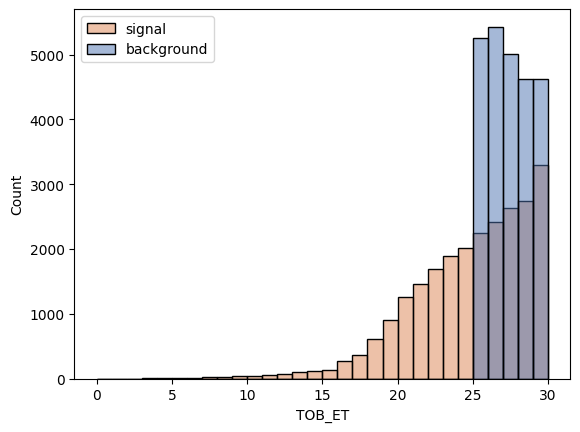

In [17]:
ax = sns.histplot( x='TOB_ET', 
                   hue='Label', 
                   data=DF_all,
                   hue_order=[0, 1],  # Specify the order if needed
                   palette='deep',    # Choose a color palette
                   binrange=(0,30),
                   bins=30
                  )
ax.set(title="")
ax.legend(["signal","background"])
plt.savefig("TOB_ET_low.png")
plt.show()

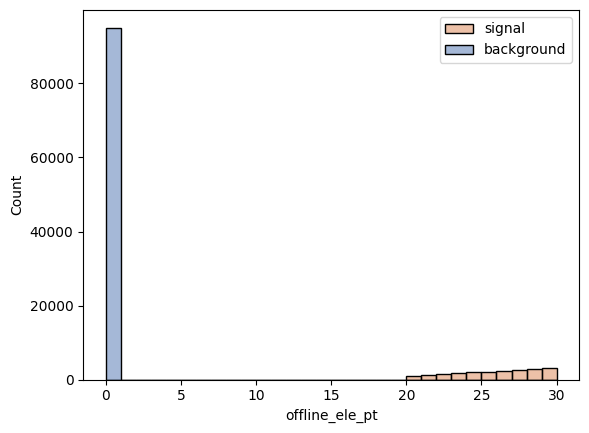

In [18]:
ax = sns.histplot( x='offline_ele_pt', 
                   hue='Label', 
                   data=DF_all,
                   hue_order=[0, 1],  # Specify the order if needed
                   palette='deep',    # Choose a color palette
                   binrange=(0,30),
                   bins=30
                  )
ax.set(title="")
ax.legend(["signal","background"])
plt.savefig("El_en_low.png")
plt.show()

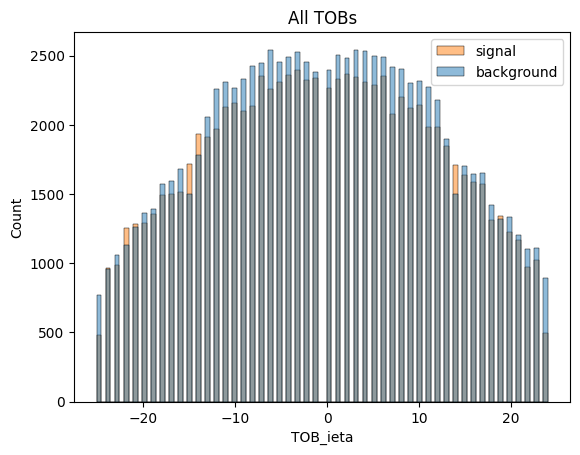

In [19]:
ax = sns.histplot( x='TOB_ieta', 
                   hue='Label', 
                   data=DF_all,
                 bins=100)
ax.set(title="All TOBs")
ax.legend(["signal","background"])
plt.savefig("TOB_ieta_all.png")
plt.show()

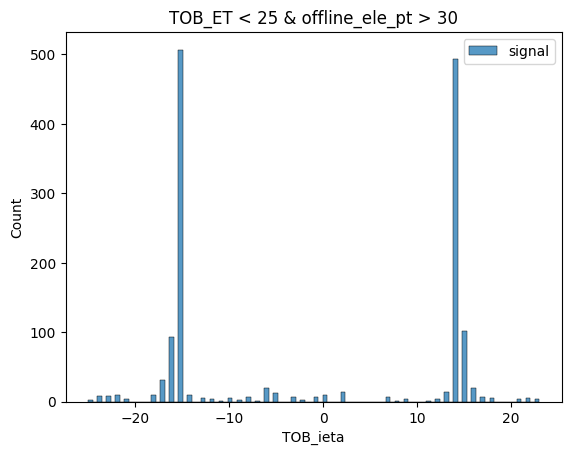

In [20]:
ax = sns.histplot( x='TOB_ieta', 
               #    hue='Label', 
                   data=DF_all.query("TOB_ET < 25 & offline_ele_pt > 30"),
                 bins=100)
ax.set(title="TOB_ET < 25 & offline_ele_pt > 30")
ax.legend(["signal","background"])
plt.savefig("TOB_ieta_bad_ones.png")
plt.show()

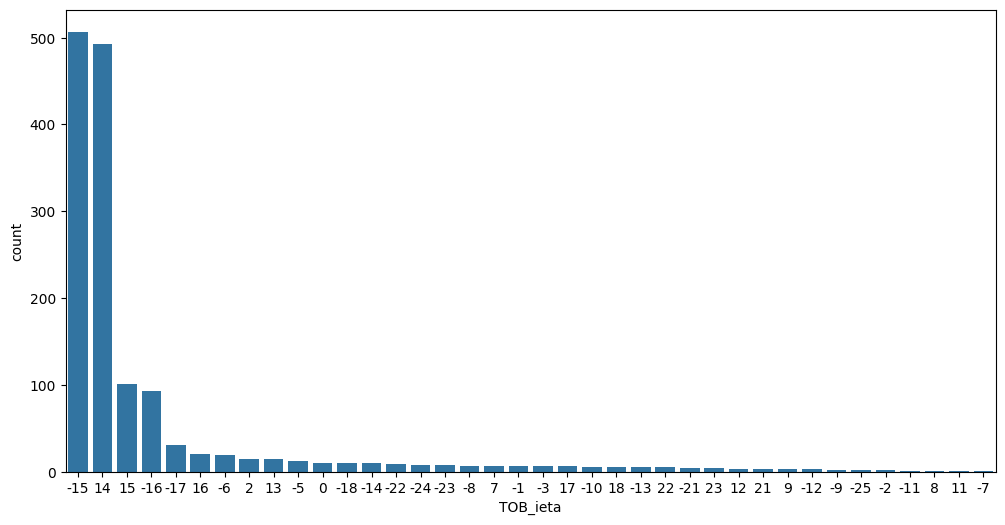

In [21]:
#sns.countplot(x="TOB_ieta",
#              data =DF_all.query("TOB_ET < 25 & offline_ele_pt > 30"))

value_counts = DF_all.query("TOB_ET < 25 & offline_ele_pt > 30")['TOB_ieta'].value_counts()
# Create order based on frequency
order = value_counts.index

# Create the plot with the specified order
plt.figure(figsize=(12, 6))
sns.countplot(data=DF_all.query("TOB_ET < 25 & offline_ele_pt > 30")
              , x='TOB_ieta', order=order)
plt.savefig("TOB_ieta_bad_ones_ordered.png")
plt.show()

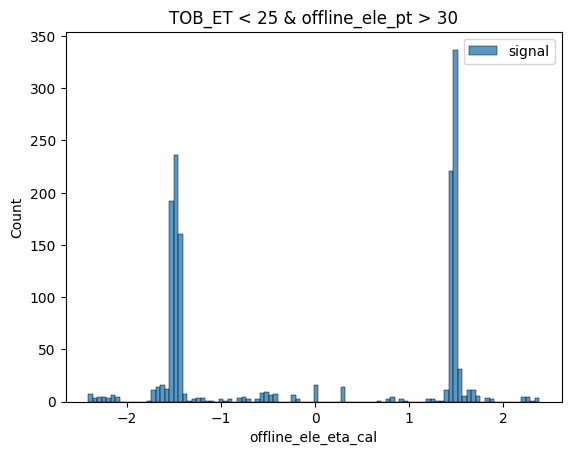

In [22]:
ax = sns.histplot( x='offline_ele_eta_cal', 
               #    hue='Label', 
                   data=DF_all.query("TOB_ET < 25 & offline_ele_pt > 30"),
                 bins=100)
ax.set(title="TOB_ET < 25 & offline_ele_pt > 30")
ax.legend(["signal","background"])
plt.savefig("offline_eta_cal_bad_ones.png")
plt.show()

In [23]:
ieta_bins_overlap=[-15,14]       # cut these eta bins out from the sample
DF_all = DF_all.query(" TOB_ieta not in @ieta_bins_overlap ")

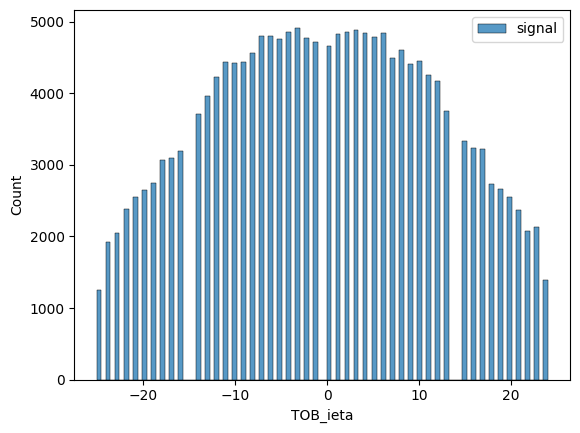

In [24]:
ax = sns.histplot( x='TOB_ieta', 
               #    hue='Label', 
                   data=DF_all,  
                #data=DF_all.query("TOB_ET < 25 & offline_ele_pt > 30"),
                 bins=100)
#ax.set(title="TOB_ET < 25 & offline_ele_pt > 30")
ax.legend(["signal","background"])
plt.savefig("TOB_ieta_bad_ones.png")
plt.show()

In [25]:
#DF_all=DF_all.query(" -8 < TOB_ieta < 8")

## Split into different Pt ranges, will train only in the middle


In [26]:
tobPtMin=25     # min threshold for eEm26
tobPtMax=60     # we switch off isolation above this cut

In [27]:
DF_lowPt  = DF_all.query("TOB_ET < @tobPtMin")
DF_midPt  = DF_all.query("TOB_ET > @tobPtMin & TOB_ET < @tobPtMax")
DF_highPt = DF_all.query("TOB_ET > @tobPtMax")

<Axes: ylabel='Frequency'>

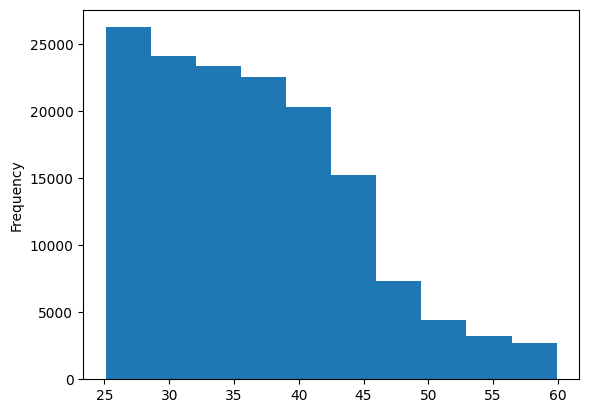

In [28]:
DF_midPt["TOB_ET"].plot(kind='hist')

In [29]:
print(DF_lowPt.shape,DF_midPt.shape,DF_highPt.shape)

(9663, 16) (149506, 16) (18404, 16)


## Check efficiencies of heuristic algorithm

We do this only in middle Pt range, that's where we want to compare with BDT

In [30]:
def analyseHeuristic(myDF):
    """
    Analyze the performance of a heuristic electron identification method using different tightness cuts.

    This function evaluates the electron identification performance by applying various tightness cuts
    to the 'ID' column of the input DataFrame. It calculates rejection rates, identification efficiencies,
    and confusion matrices for each tightness level.

    Parameters:
    -----------
    myDF : pandas.DataFrame
        A DataFrame containing at least two columns:
        - 'Label': True labels for electron identification (binary: 1 for electron, 0 for non-electron)
        - 'ID': Identification score for each event

    Returns:
    --------
    tuple
        A tuple containing three lists:
        1. id_efficiencies_heuristic: List of identification efficiencies for each tightness cut
        2. rejection_rates_heuristic: List of rejection rates for each tightness cut
        3. conf_matrices_heuristic: List of confusion matrices for each tightness cut

    The lists are ordered according to the tightness cuts: [all, loose, medium, tight]

    Notes:
    ------
    - The function uses four predefined tightness cuts: 0 (all), 1 (loose), 2 (medium), 3 (tight)
    - Identification efficiency is calculated as: true positives / (true positives + false negatives)
    - Rejection rate is calculated as: true negatives / (true negatives + false positives)
    - The function assumes that the 'Label' column contains binary values (0 or 1)
    - The function uses numpy for array operations and sklearn.metrics for confusion matrix calculation

    Example:
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> from sklearn.metrics import confusion_matrix
    >>> 
    >>> # Create a sample DataFrame
    >>> df = pd.DataFrame({
    ...     'Label': [1, 0, 1, 0, 1],
    ...     'ID': [2.7, 0.3, 1.8, 1.2, 0.7]
    ... })
    >>> 
    >>> # Call the function
    >>> efficiencies, rejections, matrices = analyseHeuristic(df)
    >>> 
    >>> print("Efficiencies:", efficiencies)
    >>> print("Rejection rates:", rejections)
    >>> print("Confusion matrices:", matrices)
    """
    # Function implementation...
    
    tightness_label = ["all","loose","medium","tight"]
    tightness_cut   = [-.1,0.5,1.5,2.5]
    rejection_rates_heuristic = []
    id_efficiencies_heuristic = []
    conf_matrices_heuristic   = []

    true_id_labels = myDF["Label"]

    for label,cut in zip(tightness_label,tightness_cut):
        electrons_identified = np.where(myDF["ID"] > cut,1,0)
        cm_heuristic_id = confusion_matrix(true_id_labels, electrons_identified)

        if (cm_heuristic_id[0][0]+cm_heuristic_id[0][1]) > 0:
            rejection_rate = cm_heuristic_id[0][0]/(cm_heuristic_id[0][0]+cm_heuristic_id[0][1])
        else:
            rejection_rate = 0.                    # no background

        if (cm_heuristic_id[1][0]+cm_heuristic_id[1][1]) > 0:
            id_efficiency  = cm_heuristic_id[1][1]/(cm_heuristic_id[1][0]+cm_heuristic_id[1][1])
        else:
            id_efficiency = 0.                         # no signals
        
        rejection_rates_heuristic.append(rejection_rate)
        id_efficiencies_heuristic.append(id_efficiency)
        conf_matrices_heuristic.append(cm_heuristic_id) 

    return id_efficiencies_heuristic,rejection_rates_heuristic,conf_matrices_heuristic

In [31]:
id_efficiencies_heuristic,rejection_rates_heuristic,conf_matrices_heuristic = \
            analyseHeuristic(DF_midPt)

In [32]:
print(id_efficiencies_heuristic,'\n',rejection_rates_heuristic)

[1.0, 0.9905439553132065, 0.9805160260672962, 0.9638515760074478] 
 [0.0, 0.8009311588352441, 0.8357150546315733, 0.8618870768071478]


In [33]:
# try adding high Pt tail
effComb,rejComb,_ = \
            analyseHeuristic(pd.concat([DF_midPt,DF_highPt]))

In [34]:
print(effComb,'\n',rejComb)

[1.0, 0.9906301889776231, 0.9806937086529085, 0.9641812287499012] 
 [0.0, 0.6467814143521536, 0.6748706915286652, 0.6960055635241448]


This looks reasonable and makes sense (unfortunately). 
We have quite a lot of events in the background in high Pt tail and for those heuristic algorithm switches off.
BDT still has some rejection power in this region so comparison looked better for it.

## Reweighting both samples in Pt

In [35]:
#DF_midPt["weight"]=1.
#DF_midPt.loc[:,"weight"]=1.

<Axes: xlabel='TOB_ET', ylabel='Count'>

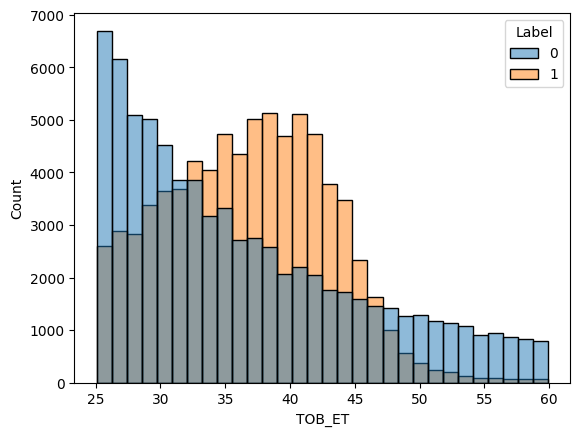

In [36]:
sns.histplot(
            data=DF_midPt,
            x="TOB_ET",
            hue="Label",
#            weights="weight",
            label=f'Weighted Pt distribution',
            alpha=0.5,
            bins=30,
    #        stat='density'
        )

In [37]:
def reweight_to_uniform_pt(df, pt_column='TOB_ET', label_column='Label', n_bins=50):
    """
    Reweight both signal and background events to achieve uniform Pt distributions.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing Pt and Label columns
    pt_column : str
        Name of the column containing Pt values
    label_column : str
        Name of the column containing labels (signal/background)
    n_bins : int
        Number of bins to use for Pt distribution
        
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with additional 'weight' column
    """
    
    # Create a copy of the input DataFrame
    df_reweighted = df.copy()
    
    # Initialize weights column
    df_reweighted['weight'] = 1.0
    
    # Process signal and background separately
    for label in df_reweighted[label_column].unique():
        # Get mask for current class
        mask = df_reweighted[label_column] == label
        
        # Calculate current Pt distribution
        hist, bin_edges = np.histogram(df_reweighted.loc[mask, pt_column], 
                                     bins=n_bins)
        
        # Calculate bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Find which bin each event belongs to
        bin_indices = np.digitize(df_reweighted.loc[mask, pt_column], bin_edges) - 1
        bin_indices = np.clip(bin_indices, 0, len(hist) - 1)
        
        # Calculate weights
        # Weight = 1 / (number of events in bin)
        weights = 1.0 / hist[bin_indices]
        
        # Normalize weights to maintain the same total number of events
        weights = weights * (len(weights) / np.sum(weights))
        
        # Assign weights to the DataFrame
        df_reweighted.loc[mask, 'weight'] = weights
    
    return df_reweighted

In [38]:
DF_midPt = reweight_to_uniform_pt(DF_midPt)

In [39]:
DF_midPt.head()

,TOB_ET,TOB_eta,TOB_ieta,TOB_ietabin,TOB_phi,offline_ele_pt,offline_ele_eta,offline_ele_eta_cal,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD,ID,Label,weight
1,32.200001,-0.5875,-6,5,-1.619884,30.928337,-0.596390,-0.588561,21.424999,0.0,29.875000,0.0,0.000,7.200,3,1,0.600319
4,38.500000,0.2125,2,2,-1.914408,36.940105,0.249134,0.218442,22.174999,0.0,35.450001,0.0,0.775,12.325,3,1,0.504462
6,46.200001,0.9375,9,9,-2.208932,41.446571,0.969867,0.946517,34.575001,1.5,40.950001,0.0,1.325,6.375,3,1,1.387269
7,40.599998,-1.2875,-13,12,2.896156,36.309994,-1.269521,-1.281316,26.924999,0.0,35.875000,0.0,0.275,6.950,3,1,0.496796
8,39.099998,-1.8625,-19,18,0.736311,41.404667,-1.871527,-1.866041,31.150000,0.0,36.474998,0.0,1.675,4.550,3,1,0.502943


<Axes: xlabel='TOB_ET', ylabel='Count'>

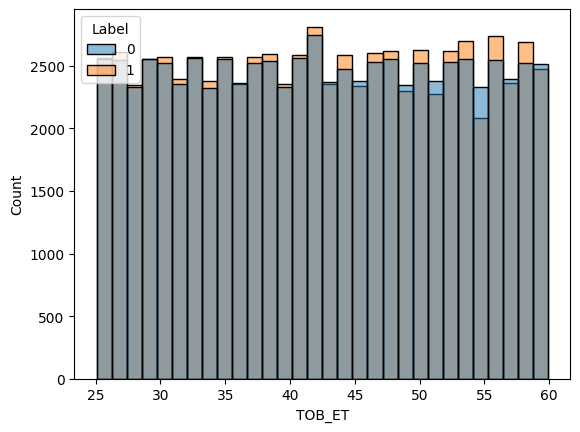

In [40]:
sns.histplot(
            data=DF_midPt,
            x="TOB_ET",
            hue="Label",
            weights="weight",
            label=f'Weighted Pt distribution',
            alpha=0.5,
            bins=30,
    #        stat='density'
        )

## Look at small BDT that may fit into eFex, compare with heuristic

In [41]:
#trainingVariables = ["eFEX_ReC", "eFEX_ReE", "eFEX_RhE" ,"eFEX_RhH" ,"eFEX_WsN","eFEX_WsD","TOB_ieta"]
trainingVariables = ["eFEX_ReC", "eFEX_ReE", "eFEX_RhE" ,"eFEX_RhH" ,"eFEX_WsN","eFEX_WsD"]
targetVariable = ['Label']

In [42]:
X_midPt = DF_midPt      # will select training variables later, need to be flexible!
y_midPt = DF_midPt[targetVariable]

In [43]:
X_midPt.head()

,TOB_ET,TOB_eta,TOB_ieta,TOB_ietabin,TOB_phi,offline_ele_pt,offline_ele_eta,offline_ele_eta_cal,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD,ID,Label,weight
1,32.200001,-0.5875,-6,5,-1.619884,30.928337,-0.596390,-0.588561,21.424999,0.0,29.875000,0.0,0.000,7.200,3,1,0.600319
4,38.500000,0.2125,2,2,-1.914408,36.940105,0.249134,0.218442,22.174999,0.0,35.450001,0.0,0.775,12.325,3,1,0.504462
6,46.200001,0.9375,9,9,-2.208932,41.446571,0.969867,0.946517,34.575001,1.5,40.950001,0.0,1.325,6.375,3,1,1.387269
7,40.599998,-1.2875,-13,12,2.896156,36.309994,-1.269521,-1.281316,26.924999,0.0,35.875000,0.0,0.275,6.950,3,1,0.496796
8,39.099998,-1.8625,-19,18,0.736311,41.404667,-1.871527,-1.866041,31.150000,0.0,36.474998,0.0,1.675,4.550,3,1,0.502943


In [44]:
print(X_midPt.shape,y_midPt.shape)

(149506, 17) (149506, 1)


In [45]:
X_train_midPt_full, X_test_midPt_full, y_train_midPt, y_test_midPt = train_test_split(X_midPt, y_midPt, test_size=0.2, random_state=42,stratify=y_midPt) 
#
X_train_midPt = X_train_midPt_full[trainingVariables]
X_train_weights = X_train_midPt_full["weight"]

X_test_midPt  = X_test_midPt_full[trainingVariables]

In [46]:
#xgb_fw = xgb.XGBClassifier(objective='binary:logistic', random_state=42,learning_rate=0.3)
xgb_fw = xgb.XGBClassifier(objective='binary:logistic', random_state=42,
                            n_estimators=32,max_depth=2,learning_rate=0.3)         # David's values

In [47]:
#xgb_fw.fit(X_train_midPt, y_train_midPt) # Train the model
xgb_fw.fit(X_train_midPt, y_train_midPt,sample_weight=X_train_weights) # Train the model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=32, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [48]:
#get output on test set
predictions_bdt_fw = xgb_fw.predict(X_test_midPt)
probs_bdt_fw = xgb_fw.predict_proba(X_test_midPt)
bdt_score_fw = xgb_fw.predict(X_test_midPt,output_margin=True)

In [49]:
print("Training score = {}".format(xgb_fw.score(X_train_midPt,y_train_midPt)))

Training score = 0.9155881074211565


In [50]:
cm_bdt_fw = confusion_matrix(y_test_midPt, predictions_bdt_fw)
print(cm_bdt_fw)

[[12635  2229]
 [  380 14658]]


In [51]:
auc_fw = roc_auc_score(y_test_midPt, probs_bdt_fw[:,1])
print(f"AUC-ROC score: {auc_fw:.3f}")

AUC-ROC score: 0.960


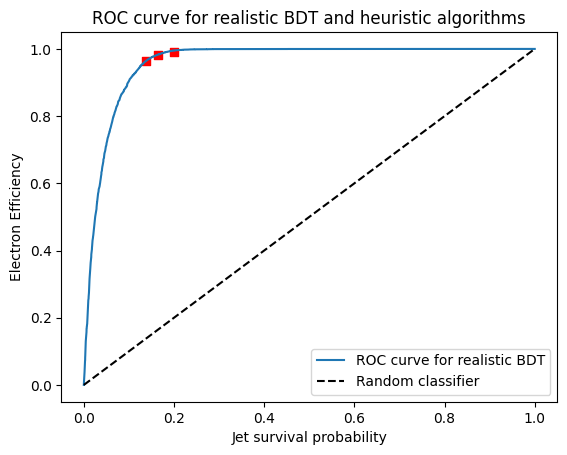

In [52]:
fpr_fw, tpr_fw, thresholds_fw = roc_curve(y_test_midPt, probs_bdt_fw[:,1])

# Plot the ROC curve
plt.figure()
plt.plot(fpr_fw, tpr_fw, label='ROC curve for realistic BDT')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('Jet survival probability')
plt.ylabel('Electron Efficiency')
plt.title('ROC curve for realistic BDT and heuristic algorithms')
plt.legend()

for i in range(1,4):
    plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s', label='Heuristic' if i == 1 else '')

plt.savefig("rBDT_heur_roc.png")
plt.show()


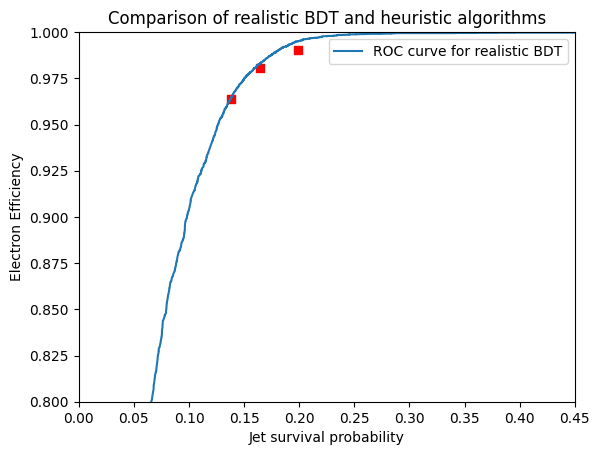

In [53]:
plt.figure()
plt.plot(fpr_fw, tpr_fw, label='ROC curve for realistic BDT')
#plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('Jet survival probability')
plt.ylabel('Electron Efficiency')
plt.title('Comparison of realistic BDT and heuristic algorithms')
plt.legend()
# adjust axes
plt.xlim(0., 0.45)
plt.ylim(0.8,1.0)

for i in range(1,4):
    plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s', label='Heuristic' if i == 1 else '')
#    plt.text(1.-rejection_rates_heuristic[i] + 0.015, id_efficiencies_heuristic[i], f'Heuristic {tightness_label[i]}', fontsize=10)

plt.savefig("bdt_heur_1.png")
plt.show()

In [54]:
# Try the same plot with error bars

In [55]:
# function generated using Claude LLM, then tweaked (messed up) by jb
# it calculates RoC curves using bootstrapping (random selection of subset of events) and from fluctuations
# estimates statistical fluctuations
def plot_roc_ci(y_true, y_score, n_bootstraps=1000, alpha=0.95,x_min=0, x_max=1, y_min=0, y_max=1,doPlot=True,title="ROC curve"):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i in range(n_bootstraps):
        # Bootstrap by sampling with replacement
        indices = np.random.randint(0, len(y_score), len(y_score))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        fpr, tpr, _ = roc_curve(y_true[indices], y_score[indices])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(np.trapz(tprs[-1], mean_fpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    fig, ax = plt.subplots()
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=f'{alpha*100:.0f}% CI')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    if doPlot:
        plt.show()

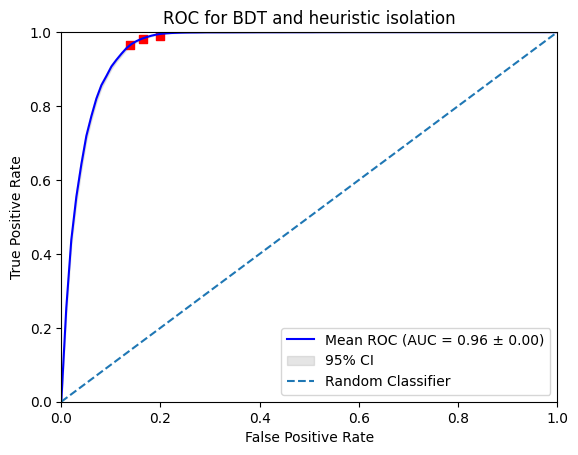

In [56]:
plot_roc_ci(y_test_midPt.values,probs_bdt_fw[:,1],x_min=0.,y_max=1.,doPlot=False,title="ROC for BDT and heuristic isolation" )

for i in range(1,4):
    plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s', label='Heuristic' if i == 1 else '')

plt.savefig("bdt_full.png")
plt.show()

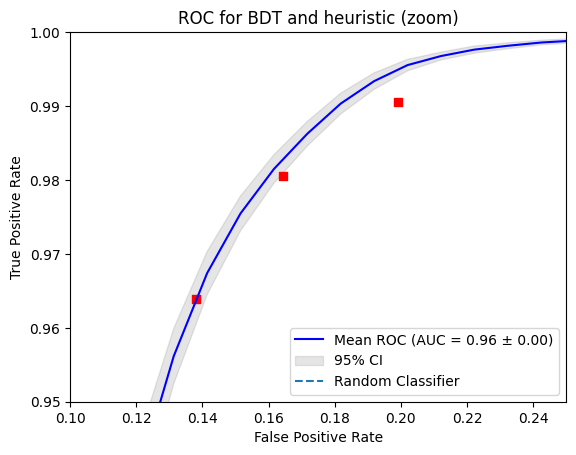

In [57]:
#plot_roc_ci(y_test_midPt.values,probs_bdt_fw[:,1],x_min=0.,x_max=0.45,y_min=0.8,y_max=1.,doPlot=False,title="ROC for realistic BDT with heuristic isolation (zoom)")
plot_roc_ci(y_test_midPt.values,probs_bdt_fw[:,1],x_min=0.1,x_max=0.25,y_min=0.95,y_max=1.,doPlot=False,title="ROC for BDT and heuristic (zoom)")

for i in range(1,4):
    plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s', label='Heuristic' if i == 1 else '')

plt.savefig("bdt_zoom.png")
plt.show()

## Merging all samples together to get full $P_T$ coverage

First need to add sample of electrons below ToB Et threshold

In [58]:
X_test_midPt_full.head()

,TOB_ET,TOB_eta,TOB_ieta,TOB_ietabin,TOB_phi,offline_ele_pt,offline_ele_eta,offline_ele_eta_cal,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD,ID,Label,weight
53012,43.299999,0.4375,4,4,-2.208932,39.687725,0.450543,0.443374,27.200001,0.625,40.049999,0.0,0.950,11.650,3,1,0.653258
157405,56.000000,-0.2625,-3,2,-2.307107,0.000000,0.000000,0.000000,37.325001,8.825,57.349998,88.5,15.175,18.025,0,0,2.663656
92064,45.599998,-1.3375,-14,13,-2.307107,0.000000,0.000000,0.000000,17.174999,0.000,38.224998,0.0,4.150,9.200,3,0,1.515107
69250,40.799999,0.6125,6,6,1.325359,41.417938,0.570527,0.611343,22.600000,0.000,37.450001,0.0,0.000,12.675,3,1,0.496796
77596,27.700001,0.8125,8,8,0.441786,30.934916,0.789992,0.813024,17.650000,1.050,23.650000,0.0,0.000,6.000,2,1,0.845782


In [59]:
X_lowPt = DF_lowPt      # will select training variables later, need to be flexible!
y_lowPt = DF_lowPt[targetVariable]

# now train test split, need to mix events and nice to have similar statistics
X_train_lowPt_full, X_test_lowPt_full, y_train_lowPt, y_test_lowPt =  \
     train_test_split(X_lowPt, y_lowPt, test_size=0.2, random_state=42,stratify=y_lowPt)

In [60]:
X_test_midPt_full.head()

,TOB_ET,TOB_eta,TOB_ieta,TOB_ietabin,TOB_phi,offline_ele_pt,offline_ele_eta,offline_ele_eta_cal,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD,ID,Label,weight
53012,43.299999,0.4375,4,4,-2.208932,39.687725,0.450543,0.443374,27.200001,0.625,40.049999,0.0,0.950,11.650,3,1,0.653258
157405,56.000000,-0.2625,-3,2,-2.307107,0.000000,0.000000,0.000000,37.325001,8.825,57.349998,88.5,15.175,18.025,0,0,2.663656
92064,45.599998,-1.3375,-14,13,-2.307107,0.000000,0.000000,0.000000,17.174999,0.000,38.224998,0.0,4.150,9.200,3,0,1.515107
69250,40.799999,0.6125,6,6,1.325359,41.417938,0.570527,0.611343,22.600000,0.000,37.450001,0.0,0.000,12.675,3,1,0.496796
77596,27.700001,0.8125,8,8,0.441786,30.934916,0.789992,0.813024,17.650000,1.050,23.650000,0.0,0.000,6.000,2,1,0.845782


In [61]:
print(X_test_midPt_full.shape,probs_bdt_fw[:,1].shape)

(29902, 17) (29902,)


In [62]:
X_test_midPt_full["Bdt_Prob"] = probs_bdt_fw[:,1]
X_test_midPt_full["Bdt_Score"] = bdt_score_fw

In [63]:
X_test_midPt_full.head(10)

,TOB_ET,TOB_eta,TOB_ieta,TOB_ietabin,TOB_phi,offline_ele_pt,offline_ele_eta,offline_ele_eta_cal,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD,ID,Label,weight,Bdt_Prob,Bdt_Score
53012,43.299999,0.4375,4,4,-2.208932,39.687725,0.450543,0.443374,27.200001,0.625,40.049999,0.0,0.950,11.650,3,1,0.653258,0.946170,2.866595
157405,56.000000,-0.2625,-3,2,-2.307107,0.000000,0.000000,0.000000,37.325001,8.825,57.349998,88.5,15.175,18.025,0,0,2.663656,0.000140,-8.875127
92064,45.599998,-1.3375,-14,13,-2.307107,0.000000,0.000000,0.000000,17.174999,0.000,38.224998,0.0,4.150,9.200,3,0,1.515107,0.819385,1.512185
69250,40.799999,0.6125,6,6,1.325359,41.417938,0.570527,0.611343,22.600000,0.000,37.450001,0.0,0.000,12.675,3,1,0.496796,0.954524,3.044021
77596,27.700001,0.8125,8,8,0.441786,30.934916,0.789992,0.813024,17.650000,1.050,23.650000,0.0,0.000,6.000,2,1,0.845782,0.854062,1.766826
124725,34.200001,0.4125,4,4,2.896156,0.000000,0.000000,0.000000,28.700001,8.200,34.625000,24.0,1.950,4.350,0,0,0.742418,0.000440,-7.728254
74470,39.299999,-2.3625,-24,23,1.325359,37.178898,-2.382566,-2.383368,27.650000,1.375,35.150002,0.0,0.975,6.525,3,1,0.502943,0.727836,0.983671
17994,28.000000,2.4375,24,24,-0.343612,26.688581,2.457409,2.458116,20.525000,0.000,24.900000,0.0,0.000,0.000,3,1,0.821300,0.673555,0.724309
155778,51.700001,2.2625,22,22,-2.601631,0.000000,0.000000,0.000000,30.424999,2.600,46.625000,1.0,2.500,15.550,2,0,2.215082,0.085548,-2.369248
95143,37.099998,-0.0625,-1,0,1.129010,0.000000,0.000000,0.000000,23.025000,5.600,34.525002,7.0,5.775,11.450,0,0,0.918048,0.000405,-7.810936


In [64]:
X_test_lowPt_full["Bdt_Prob"] = -1.     # below ToB Pt threshold
X_test_lowPt_full["Bdt_Score"] = -100     # below ToB Pt threshold

In [65]:
X_test_lowPt_full.head(10)

,TOB_ET,TOB_eta,TOB_ieta,TOB_ietabin,TOB_phi,offline_ele_pt,offline_ele_eta,offline_ele_eta_cal,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD,ID,Label,Bdt_Prob,Bdt_Score
5183,24.200001,-0.3625,-4,3,0.245437,26.528650,-0.394457,-0.360491,12.800000,0.0,22.299999,0.0,0.000,8.450,3,1,-1.0,-100
71832,19.200001,1.0375,10,10,0.343612,21.545616,1.002083,1.031086,9.525000,0.0,16.625000,0.0,0.650,4.325,3,1,-1.0,-100
65089,23.500000,0.1375,1,1,-2.797981,25.755001,0.135409,0.142702,16.225000,0.0,21.799999,0.0,0.000,5.575,3,1,-1.0,-100
48298,21.900000,-2.1125,-22,21,-1.325359,23.458000,-2.117181,-2.124835,9.875000,0.0,19.750000,0.0,1.225,9.875,3,1,-1.0,-100
27896,24.799999,1.5875,15,15,-1.325359,26.754662,1.592299,1.587835,13.350000,0.0,22.799999,0.0,3.275,8.075,3,1,-1.0,-100
30001,24.500000,-0.0875,-1,0,-1.521709,24.818016,-0.122660,-0.096063,16.799999,0.0,22.575001,0.0,0.900,5.775,3,1,-1.0,-100
87778,21.500000,-1.5125,-16,15,-2.208932,26.164639,-1.529132,-1.528026,6.825000,0.0,17.875000,0.0,1.600,7.950,3,1,-1.0,-100
19656,24.900000,1.2375,12,12,1.129010,26.157457,1.223650,1.239274,12.975000,0.7,21.475000,0.0,0.300,5.575,3,1,-1.0,-100
80580,22.600000,-0.6375,-7,6,-2.012583,22.813141,-0.618737,-0.625904,12.075000,0.0,20.525000,0.0,1.550,8.450,3,1,-1.0,-100
63094,21.100000,0.9375,9,9,-1.423534,22.574511,0.948846,0.924619,11.625000,0.0,18.174999,0.0,2.200,4.550,3,1,-1.0,-100


<Axes: ylabel='Frequency'>

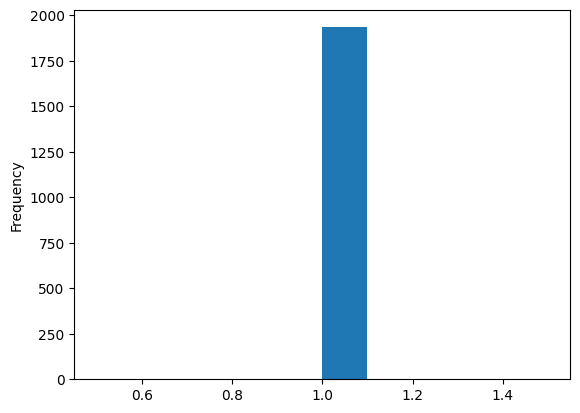

In [66]:
X_test_lowPt_full["Label"].plot(kind='hist')  # ah, ok, don't have background below 25 GeV, don't really need for efficiency

In [67]:

X_highPt = DF_highPt      # will select training variables later, as for previous set 
y_highPt = DF_highPt[targetVariable]

# now train test split, need to mix events and nice to have similar statistics
X_train_highPt_full, X_test_highPt_full, y_train_highPt, y_test_highPt =  \
     train_test_split(X_highPt, y_highPt, test_size=0.2, random_state=42,stratify=y_highPt)

In [68]:
X_test_highPt_full["Bdt_Prob"] = 2            # in this region we accept everything
X_test_highPt_full["Bdt_Score"] = 100            # in this region we accept everything

In [69]:
X_test_highPt_full.head()

,TOB_ET,TOB_eta,TOB_ieta,TOB_ietabin,TOB_phi,offline_ele_pt,offline_ele_eta,offline_ele_eta_cal,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD,ID,Label,Bdt_Prob,Bdt_Score
131275,85.400002,0.4875,4,4,2.208932,0.0,0.0,0.0,59.049999,6.050,80.750000,13.5,6.950,20.250000,3,0,2,100
116547,88.199997,-1.0625,-11,10,-0.932660,0.0,0.0,0.0,47.650002,6.525,79.349998,1.0,6.125,16.575001,3,0,2,100
140833,119.699997,-0.8375,-9,8,0.245437,0.0,0.0,0.0,74.675003,2.975,104.125000,0.0,8.900,21.650000,3,0,2,100
123769,85.000000,-0.4375,-5,4,0.441786,0.0,0.0,0.0,67.925003,2.300,81.675003,17.0,8.125,12.350000,3,0,2,100
105901,87.500000,1.0625,10,10,0.245437,0.0,0.0,0.0,50.724998,2.275,76.599998,1.5,1.375,18.975000,3,0,2,100


In [70]:
X_test_fullPt = pd.concat([X_test_lowPt_full,X_test_midPt_full,X_test_highPt_full])   # all together

In [71]:
X_test_fullPt.shape

(35516, 19)

<Axes: xlabel='offline electron Pt', ylabel='Frequency'>

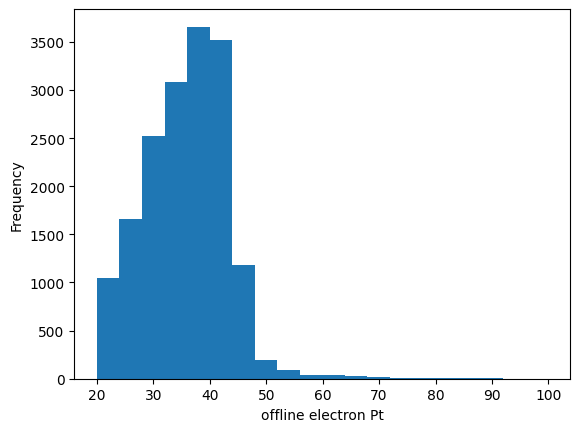

In [72]:
X_test_fullPt.query("offline_ele_pt < 100 & Label==1")["offline_ele_pt"].plot(kind='hist',bins=20,xlabel="offline electron Pt")

Good, this looks reasonable and smooth, can do few studies

## Trigger Efficiencies and jet rejection rates

In [73]:
#X_test_fullPt = X_test_fullPt.query("(TOB_eta < -1.6) or (-1.4 < TOB_eta < 1.4) or (TOB_eta > 1.6)") # get rid of overlap region

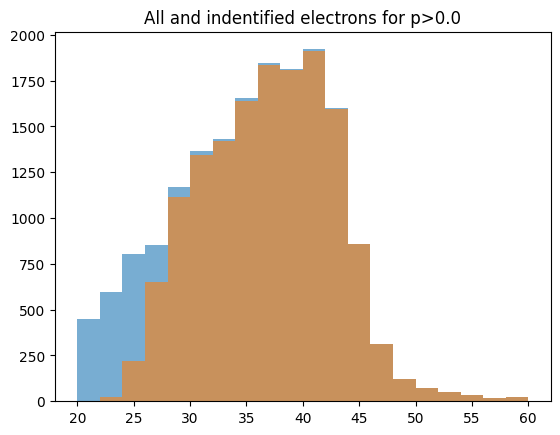

0.0 [0.00894855 0.04180602 0.2761194  0.76436108 0.9545844  0.98462665
 0.99092179 0.99213551 0.99242014 0.99724214 0.9958355  0.996875
 0.997669   1.         1.         1.         1.         1.
 1.         1.        ]


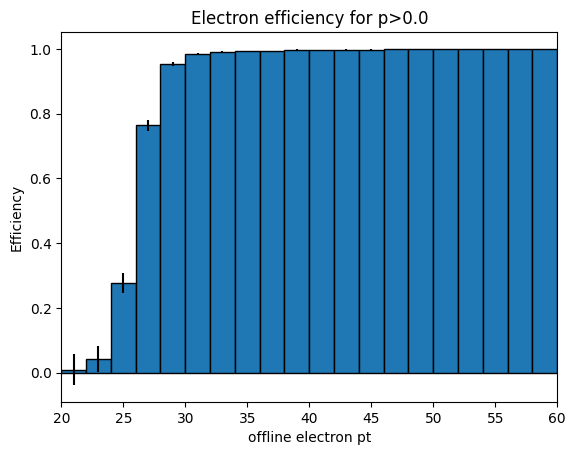

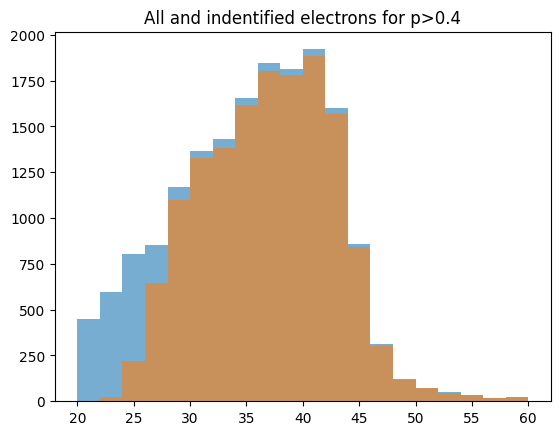

0.4 [0.00894855 0.04180602 0.27114428 0.75381008 0.94001714 0.97144949
 0.96368715 0.97701149 0.976719   0.98124655 0.98021864 0.979375
 0.98018648 0.97106109 0.97520661 0.94666667 0.95833333 0.97142857
 1.         1.        ]


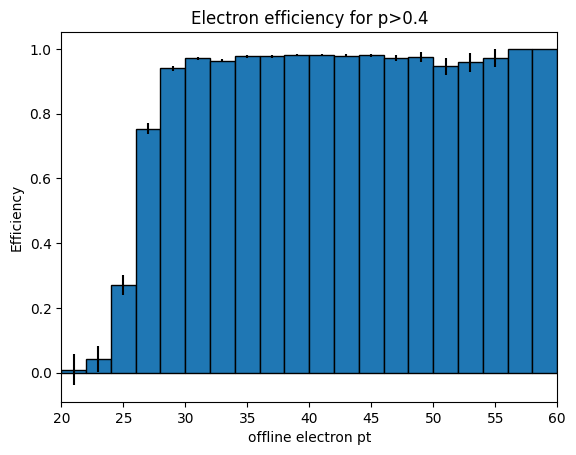

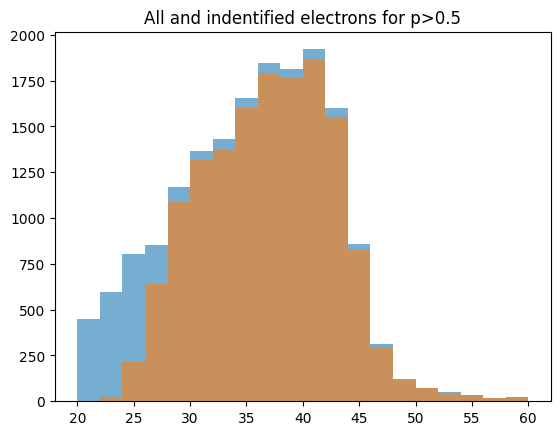

0.5 [0.00894855 0.04013378 0.2699005  0.74912075 0.93316195 0.96486091
 0.95670391 0.96672716 0.97130482 0.97297297 0.97345133 0.970625
 0.96969697 0.95819936 0.96694215 0.93333333 0.95833333 0.94285714
 1.         1.        ]


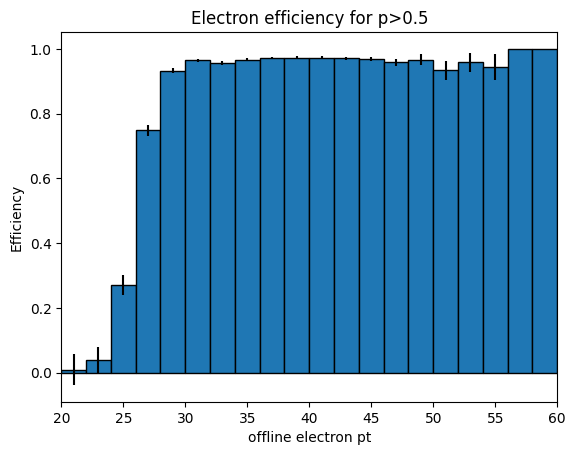

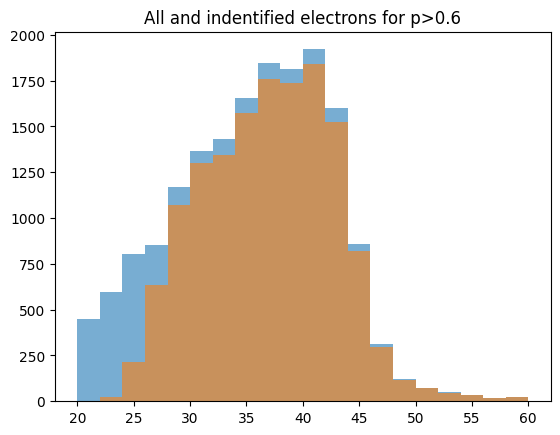

0.6 [0.00894855 0.04013378 0.26616915 0.74443142 0.91945159 0.95168375
 0.93924581 0.95099819 0.95343801 0.95918367 0.95679334 0.953125
 0.95804196 0.94533762 0.95867769 0.93333333 0.91666667 0.91428571
 0.95       1.        ]


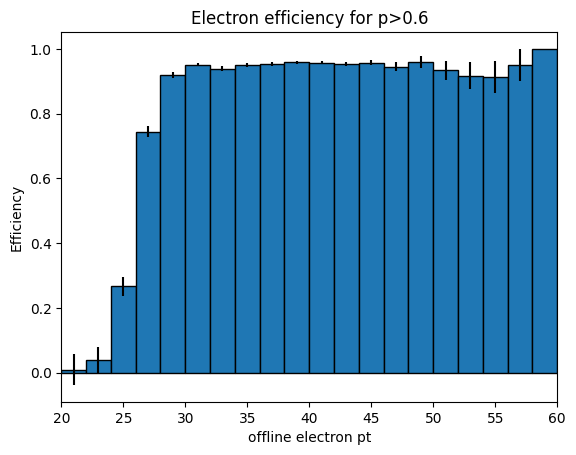

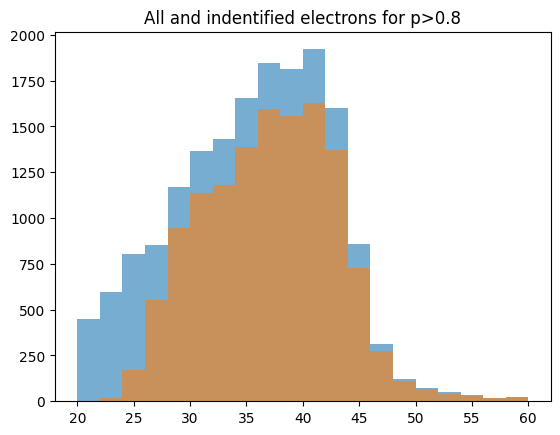

0.8 [0.00894855 0.03344482 0.21393035 0.64830012 0.80891174 0.83089312
 0.8226257  0.83908046 0.86302112 0.85990072 0.8485164  0.85875
 0.85081585 0.8778135  0.91735537 0.86666667 0.8125     0.85714286
 0.9        0.95833333]


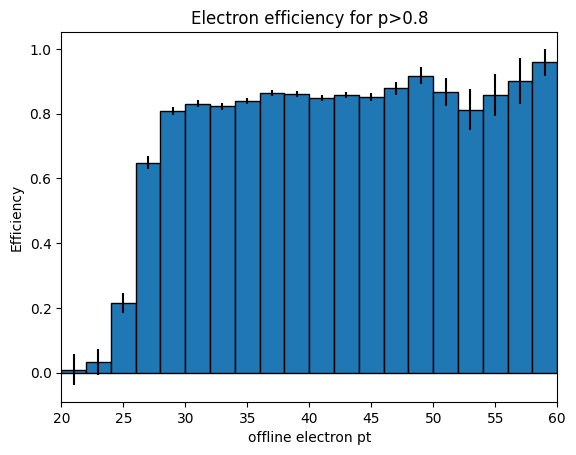

In [74]:
prob_thrs = [0.,0.4,0.5,0.6,0.8]

for prob_thr in prob_thrs:
    et_Low=20.
    et_High=60.

    electrons_all,bins,_ = plt.hist( X_test_fullPt.query("Label == 1")["offline_ele_pt"],
                               bins=20,range=[et_Low,et_High],alpha=0.6)
    electrons_all_tagged,bins,_ = plt.hist( X_test_fullPt.query("Label == 1 & Bdt_Prob >= @prob_thr")["offline_ele_pt"],
                               bins=20,range=[et_Low,et_High],alpha=0.6)
    plt.title('All and indentified electrons for p>'+str(prob_thr))
    plt.savefig("Pt_el_prob"+str(prob_thr)+".png")
    plt.show()

    electrons_efficiency = electrons_all_tagged/electrons_all
    print(prob_thr,electrons_efficiency)
    efficiency_error = np.sqrt(electrons_efficiency*(1-electrons_efficiency)/electrons_all_tagged)

    width = np.diff(bins)
    left_edges = bins[:-1]
    plt.bar(left_edges, electrons_efficiency, yerr=efficiency_error, width=width, align='edge', edgecolor='black')
    plt.title('Electron efficiency for p>'+str(prob_thr))
    plt.xlabel('offline electron pt')
    plt.ylabel('Efficiency')
    plt.xlim(bins[0], bins[-1])
    plt.savefig("Pt_el_eff"+str(prob_thr)+".png")
    plt.show()

In [75]:
#Now the same using a function

In [76]:
from typing import List, Tuple
def analyze_electron_efficiency(
    data: pd.DataFrame,
    prob_thresholds: List[float] = [0.0, 0.4, 0.5, 0.6, 0.8],
    et_range: Tuple[float, float] = (20.0, 60.0),
    n_bins: int = 20,
    save_dir: str = "./",
    display_plots: bool = True,
) -> dict:
    """
    Analyze and plot electron selection efficiency using BDT probability threshold.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input DataFrame containing 'Label', 'Bdt_Prob', and 'offline_ele_pt' columns
    prob_thresholds : List[float]
        List of probability thresholds to analyze
    et_range : Tuple[float, float]
        Range of electron ET to consider (min, max)
    n_bins : int
        Number of bins for histograms
    save_dir : str
        Directory to save output plots
    display_plots : bool
        If True, display plots in the notebook
        
    Returns:
    --------
    dict
        Dictionary containing efficiency results for each threshold
    """
    results = {}
    
    for prob_thr in prob_thresholds:
        # Create figure for distribution plot
        fig_dist, ax_dist = plt.subplots(figsize=(10, 6))
        
        # Plot all electrons
        electrons_all, bins, _ = ax_dist.hist(
            data.query("Label == 1")["offline_ele_pt"],
            bins=n_bins,
            range=et_range,
            alpha=0.6,
            label='All electrons'
        )
        
        # Plot tagged electrons
        electrons_all_tagged, _, _ = ax_dist.hist(
            data.query("Label == 1 & Bdt_Prob >= @prob_thr")["offline_ele_pt"],
            bins=bins,
            alpha=0.6,
            label=f'Identified electrons (p>{prob_thr})'
        )
        
        ax_dist.set_title(f'Electron PT Distribution (p>{prob_thr})')
        ax_dist.set_xlabel('Offline Electron PT [GeV]')
        ax_dist.set_ylabel('Count')
        ax_dist.legend()
        
        # Save distribution plot
        fig_dist.savefig(f"{save_dir}/Pt_el_prob_{prob_thr:.1f}.png")
        if display_plots:
            plt.show()
        else:
            plt.close(fig_dist)
        
        # Calculate efficiency and errors
        electrons_efficiency = np.divide(
            electrons_all_tagged,
            electrons_all,
            out=np.zeros_like(electrons_all_tagged, dtype=float),
            where=electrons_all!=0
        )
        
        efficiency_error = np.sqrt(
            electrons_efficiency * (1 - electrons_efficiency) / np.maximum(electrons_all_tagged, 1)
        )
        
        # Create figure for efficiency plot
        fig_eff, ax_eff = plt.subplots(figsize=(10, 6))
        
        width = np.diff(bins)
        left_edges = bins[:-1]
        
        ax_eff.bar(
            left_edges,
            electrons_efficiency,
            yerr=efficiency_error,
            width=width,
            align='edge',
            edgecolor='black',
            alpha=0.7
        )
        
        ax_eff.set_title(f'Electron Selection Efficiency (p>{prob_thr})')
        ax_eff.set_xlabel('Offline Electron PT [GeV]')
        ax_eff.set_ylabel('Efficiency')
        ax_eff.set_xlim(bins[0], bins[-1])
        ax_eff.set_ylim(0, 1.2)  # Set y-axis limit for efficiency
        ax_eff.grid(True, alpha=0.3)
        
        # Save efficiency plot
        fig_eff.savefig(f"{save_dir}/Pt_el_eff_{prob_thr:.1f}.png")
        if display_plots:
            plt.show()
        else:
            plt.close(fig_eff)
        
        # Store results
        results[prob_thr] = {
            'efficiency': electrons_efficiency,
            'error': efficiency_error,
            'bins': bins,
            'n_total': electrons_all,
            'n_tagged': electrons_all_tagged
        }
    
    return results

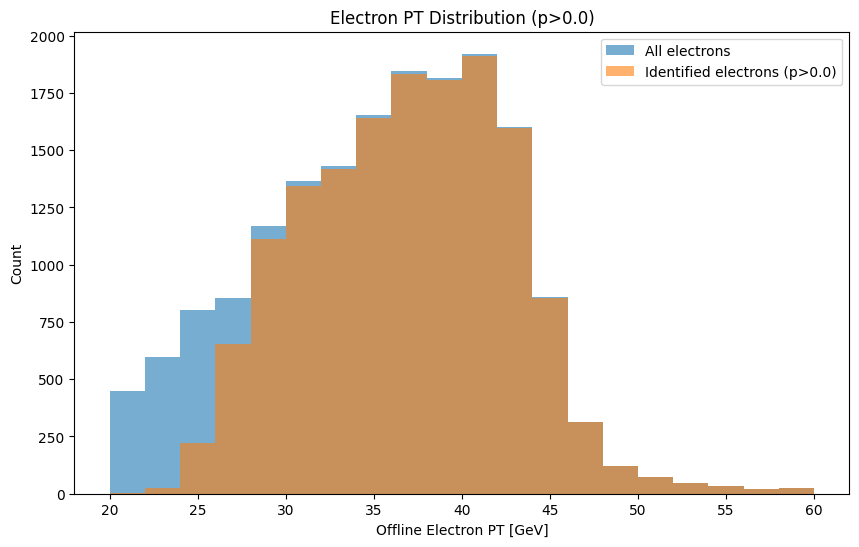

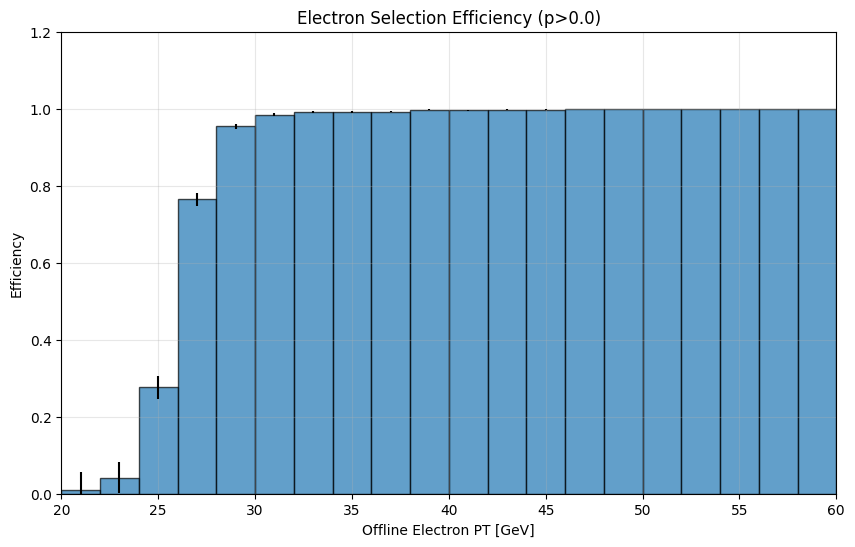

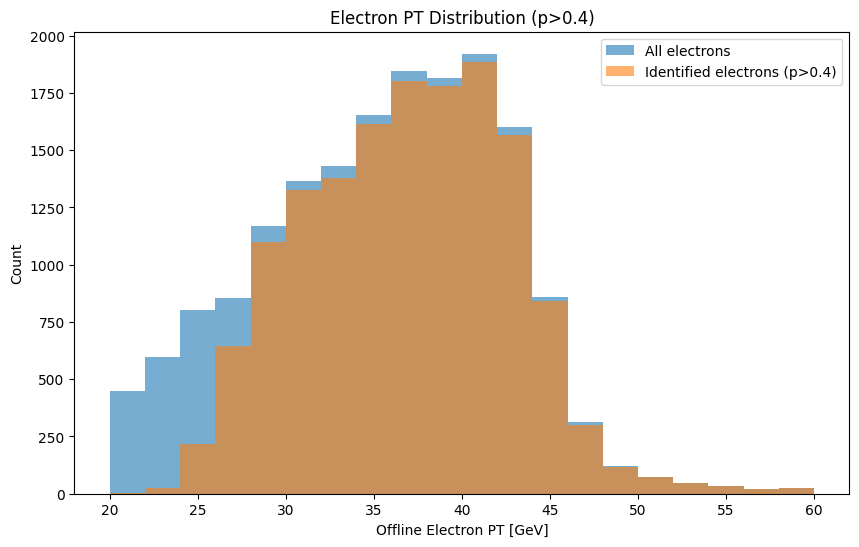

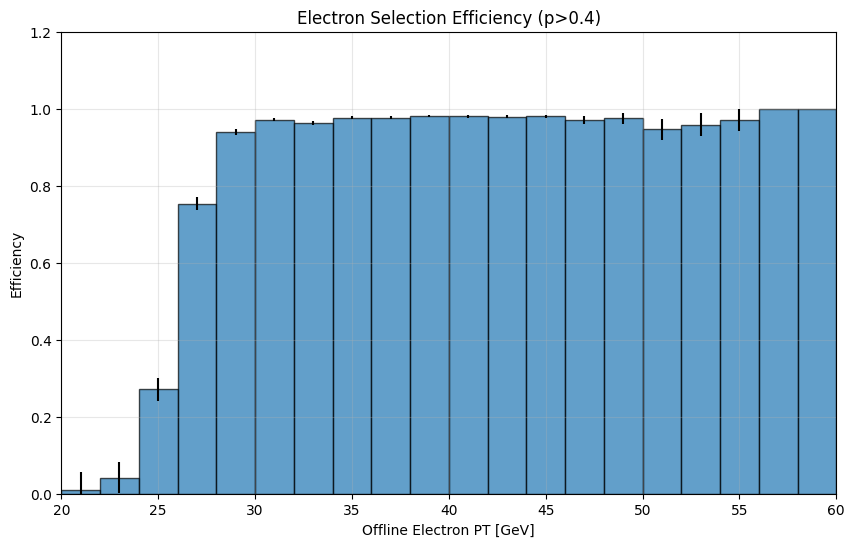

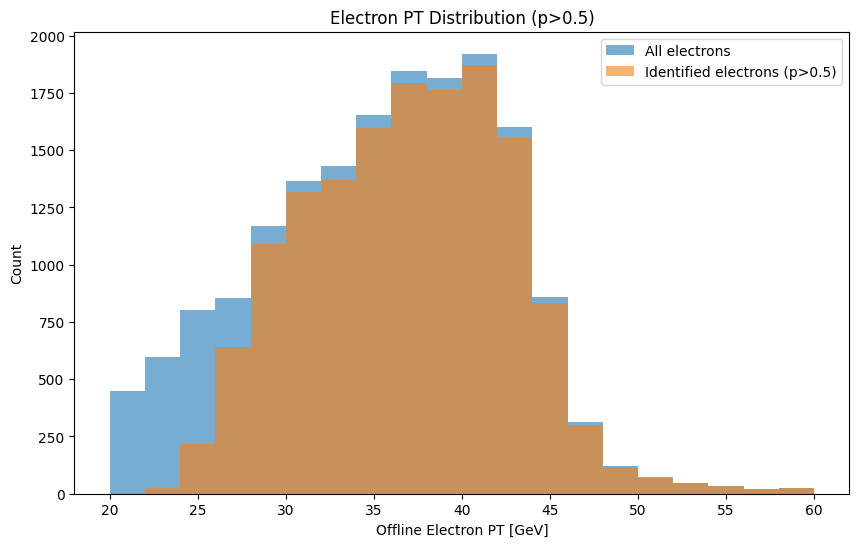

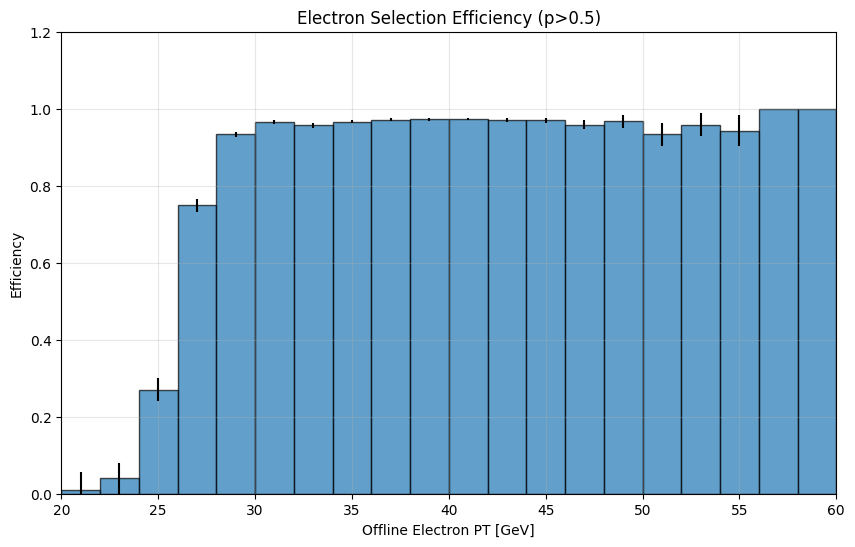

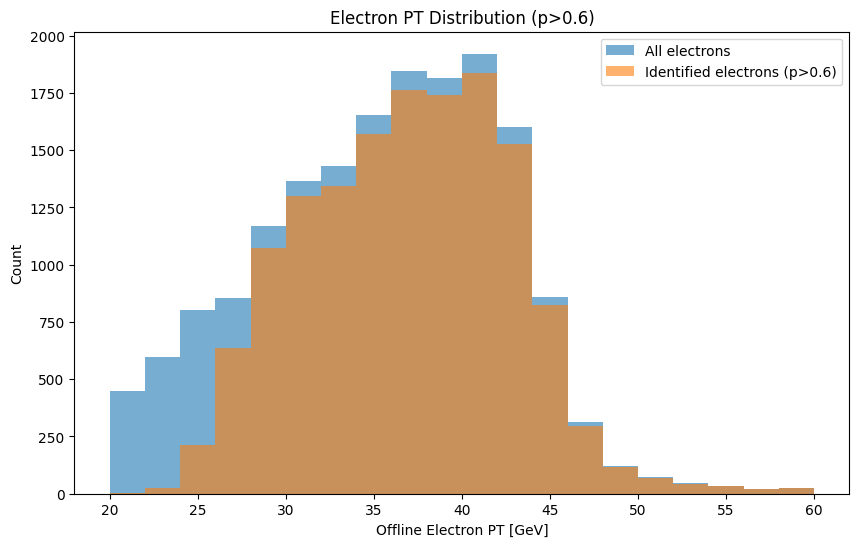

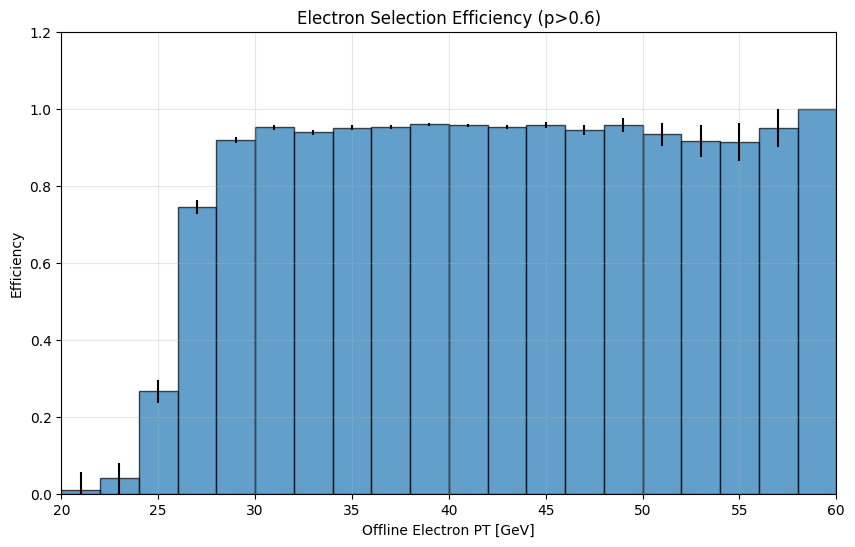

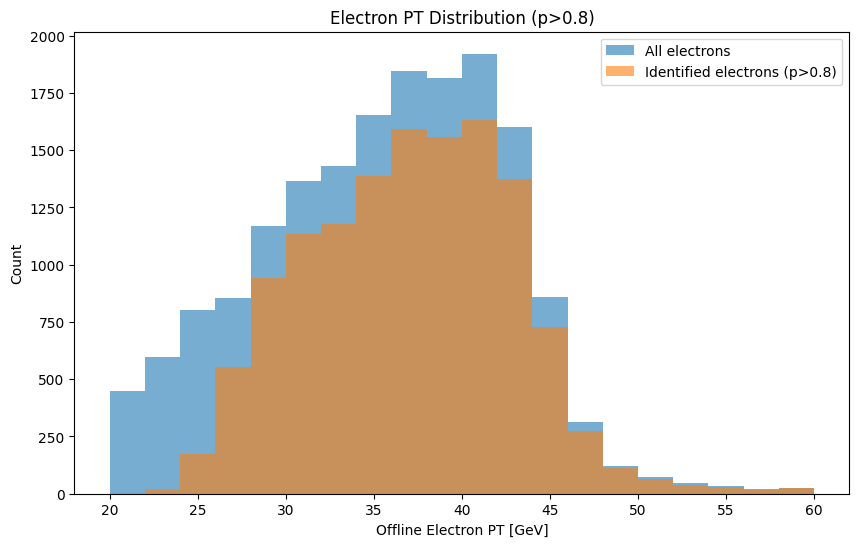

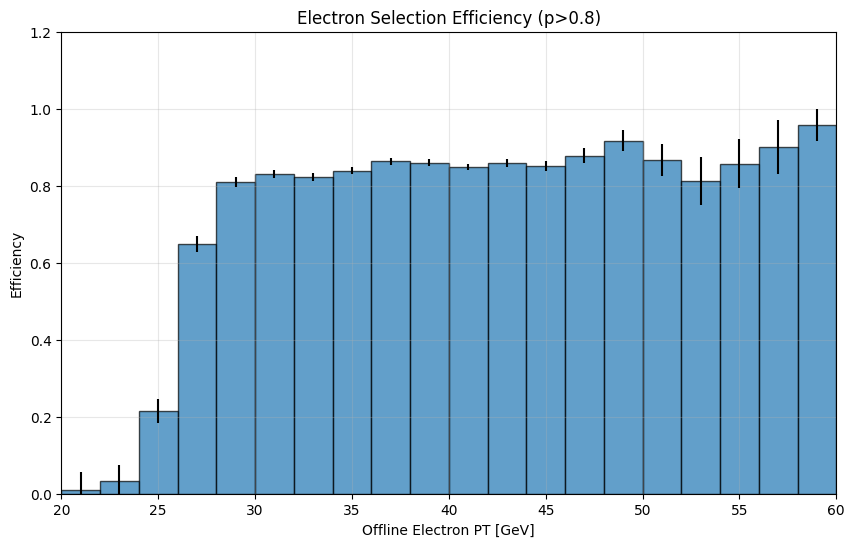

{0.0: {'efficiency': array([0.00894855, 0.04180602, 0.2761194 , 0.76436108, 0.9545844 ,
         0.98462665, 0.99092179, 0.99213551, 0.99242014, 0.99724214,
         0.9958355 , 0.996875  , 0.997669  , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ]),
  'error': array([0.04708628, 0.04002913, 0.03000582, 0.01662069, 0.00623831,
         0.00335474, 0.00251784, 0.00218122, 0.0020258 , 0.00123335,
         0.00147237, 0.00139754, 0.00164827, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]),
  'bins': array([20., 22., 24., 26., 28., 30., 32., 34., 36., 38., 40., 42., 44.,
         46., 48., 50., 52., 54., 56., 58., 60.]),
  'n_total': array([ 447.,  598.,  804.,  853., 1167., 1366., 1432., 1653., 1847.,
         1813., 1921., 1600.,  858.,  311.,  121.,   75.,   48.,   35.,
           20.,   24.]),
  'n_tagged': array([   4.,   25.,  222.,  652., 1114., 1345., 1419., 1640., 1833.,
         1808., 191

In [77]:
analyze_electron_efficiency(X_test_fullPt)        # test it

In [78]:
from typing import List, Tuple
def analyze_jet_suppression(
    data: pd.DataFrame,
    prob_thresholds: List[float] = [0.0, 0.4, 0.5, 0.6, 0.8],
    et_range: Tuple[float, float] = (20.0, 60.0),
    n_bins: int = 20,
    save_dir: str = "./",
    display_plots: bool = True,
) -> dict:
    """
    Analyze and plot jet suppression rates using BDT probability threshold.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input DataFrame containing 'Label', 'Bdt_Prob', and 'offline_ele_pt' columns
    prob_thresholds : List[float]
        List of probability thresholds to analyze
    et_range : Tuple[float, float]
        Range of TOB ET to consider (min, max)
    n_bins : int
        Number of bins for histograms
    save_dir : str
        Directory to save output plots
    display_plots : bool
        If True, display plots in the notebook
        
    Returns:
    --------
    dict
        Dictionary containing efficiency results for each threshold
    """
    results = {}
    
    for prob_thr in prob_thresholds:
        # Create figure for distribution plot
        fig_dist, ax_dist = plt.subplots(figsize=(10, 6))
        
        # Plot all electrons
        jets_all, bins, _ = ax_dist.hist(
            data.query("Label == 0")["TOB_ET"],
            bins=n_bins,
            range=et_range,
            alpha=0.6,
            label='All jets'
        )
        
        # Plot jets tagged as electrons
        jets_all_tagged, _, _ = ax_dist.hist(
            data.query("Label == 0 & Bdt_Prob >= @prob_thr")["TOB_ET"],
            bins=bins,
            alpha=0.6,
            label=f'Jets (p(electron)>{prob_thr})'
        )
        
        ax_dist.set_title(f'Jet TOB_ET Distribution (p>{prob_thr})')
        ax_dist.set_xlabel('TOB PT [GeV]')
        ax_dist.set_ylabel('Count')
        ax_dist.legend()
        
        # Save distribution plot
        fig_dist.savefig(f"{save_dir}/Pt_Jet_prob_{prob_thr:.1f}.png")
        if display_plots:
            plt.show()
        else:
            plt.close(fig_dist)
        
        # Calculate survival rate and errors
        jets_survival = np.divide(
            jets_all_tagged,
            jets_all,
            out=np.zeros_like(jets_all_tagged, dtype=float),
            where=electrons_all!=0
        )
        
        survival_error = np.sqrt(
            jets_survival * (1 - jets_survival) / np.maximum(jets_all_tagged, 1)
        )
        
        # Create figure for survival plot
        fig_eff, ax_eff = plt.subplots(figsize=(10, 6))
        
        width = np.diff(bins)
        left_edges = bins[:-1]
        
        ax_eff.bar(
            left_edges,
            jets_survival,
            yerr=survival_error,
            width=width,
            align='edge',
            edgecolor='black',
            alpha=0.7
        )
        
        ax_eff.set_title(f'Jet survival rate (p(electron)>{prob_thr})')
        ax_eff.set_xlabel('TOB PT [GeV]')
        ax_eff.set_ylabel('Survival rate')
        ax_eff.set_xlim(bins[0], bins[-1])
        #ax_eff.set_ylim(0, 1.2)  # Set y-axis limit for efficiency
        ax_eff.set_ylim(0, 0.5)  # Set y-axis limit for efficiency
        ax_eff.grid(True, alpha=0.3)
        
        # Save efficiency plot
        fig_eff.savefig(f"{save_dir}/Pt_jet_eff_{prob_thr:.1f}.png")
        if display_plots:
            plt.show()
        else:
            plt.close(fig_eff)
        
        # Store results
        results[prob_thr] = {
            'efficiency': electrons_efficiency,
            'error': efficiency_error,
            'bins': bins,
            'n_total': electrons_all,
            'n_tagged': electrons_all_tagged
        }
    
    return results

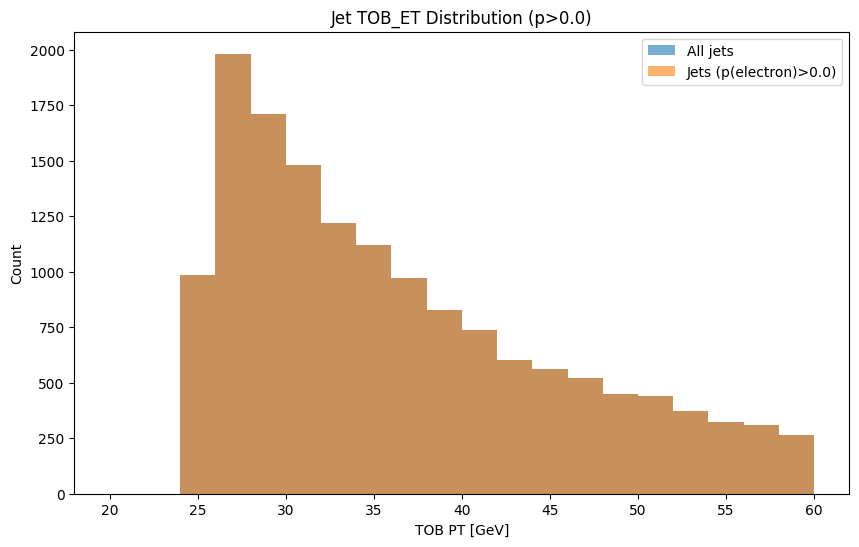

/tmp/ipykernel_63287/3875673871.py:69: RuntimeWarning: invalid value encountered in divide
  jets_survival = np.divide(


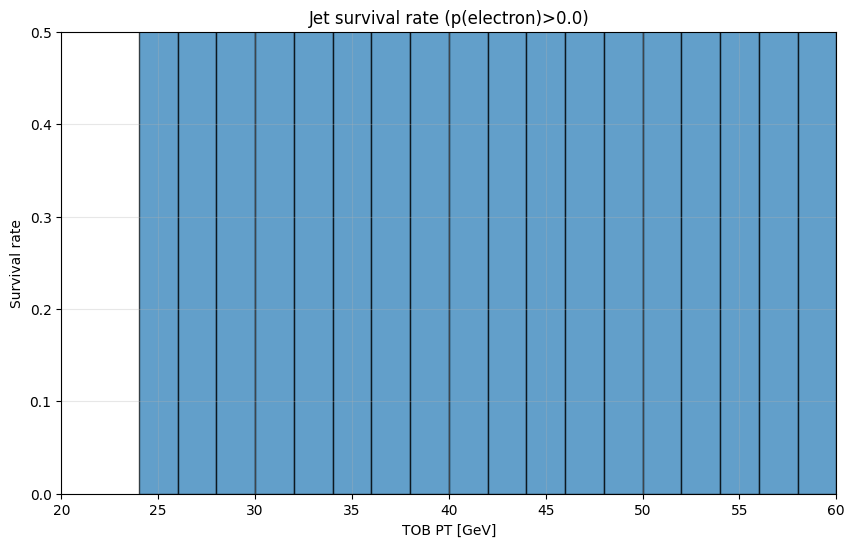

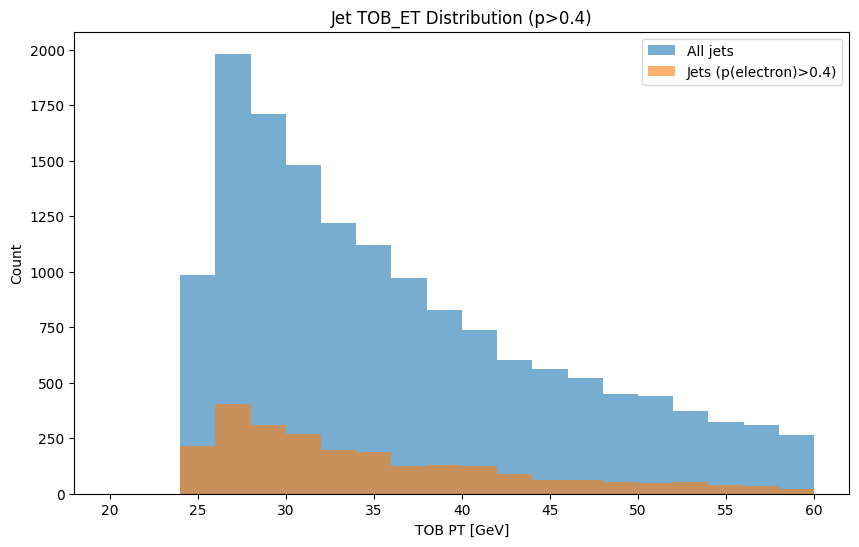

/tmp/ipykernel_63287/3875673871.py:69: RuntimeWarning: invalid value encountered in divide
  jets_survival = np.divide(


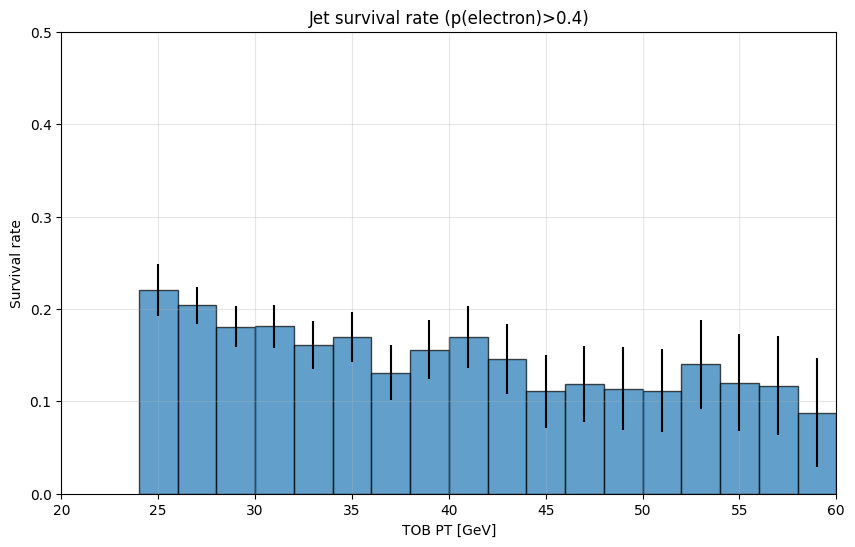

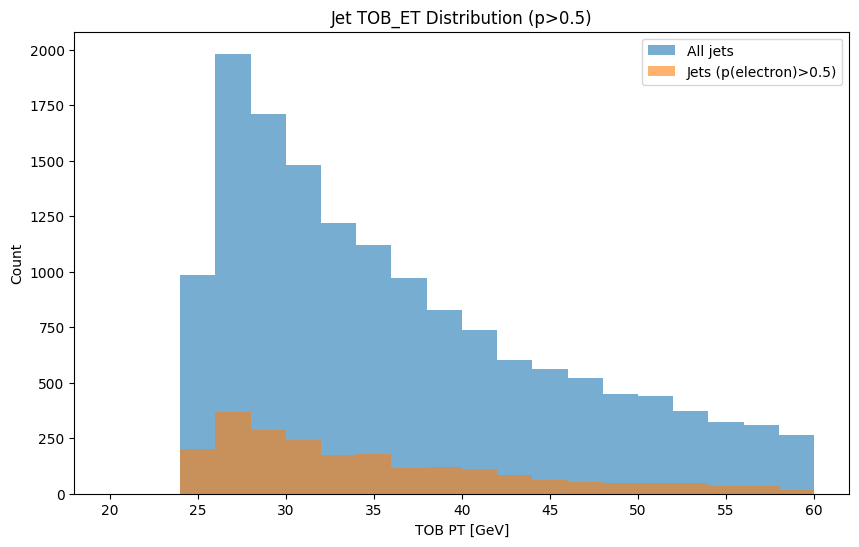

/tmp/ipykernel_63287/3875673871.py:69: RuntimeWarning: invalid value encountered in divide
  jets_survival = np.divide(


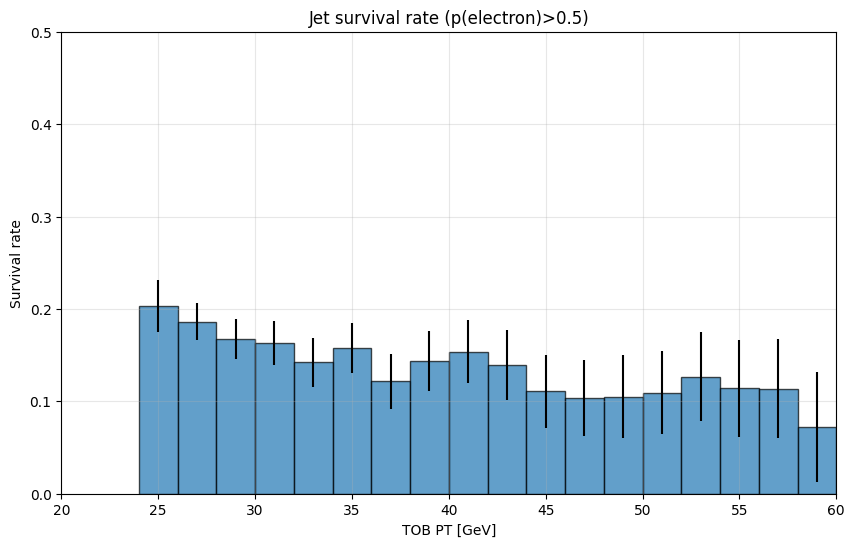

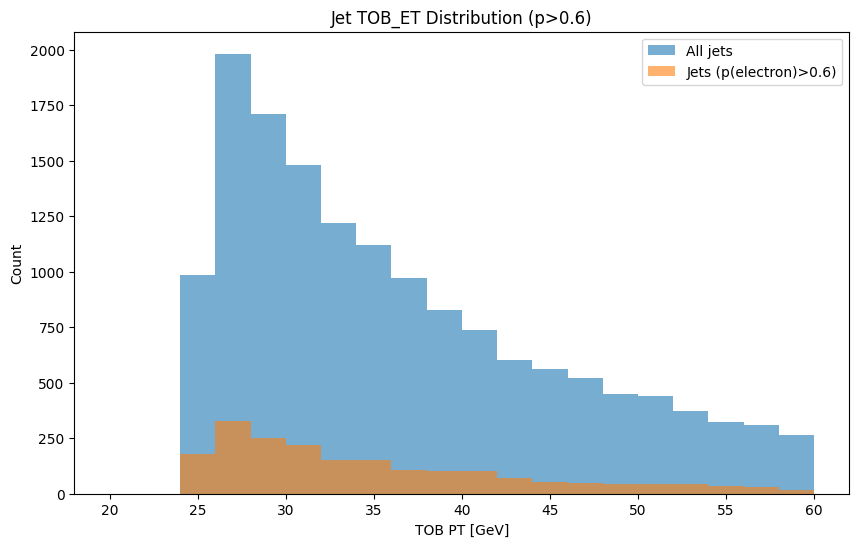

/tmp/ipykernel_63287/3875673871.py:69: RuntimeWarning: invalid value encountered in divide
  jets_survival = np.divide(


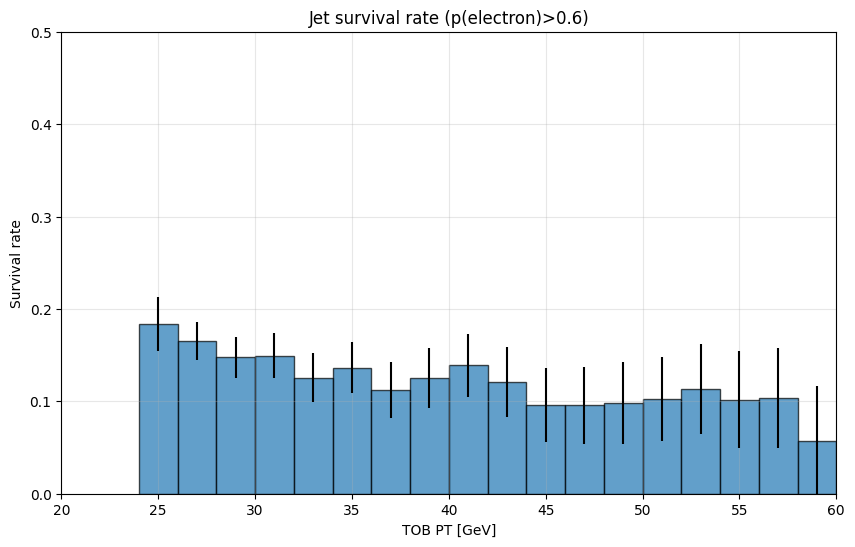

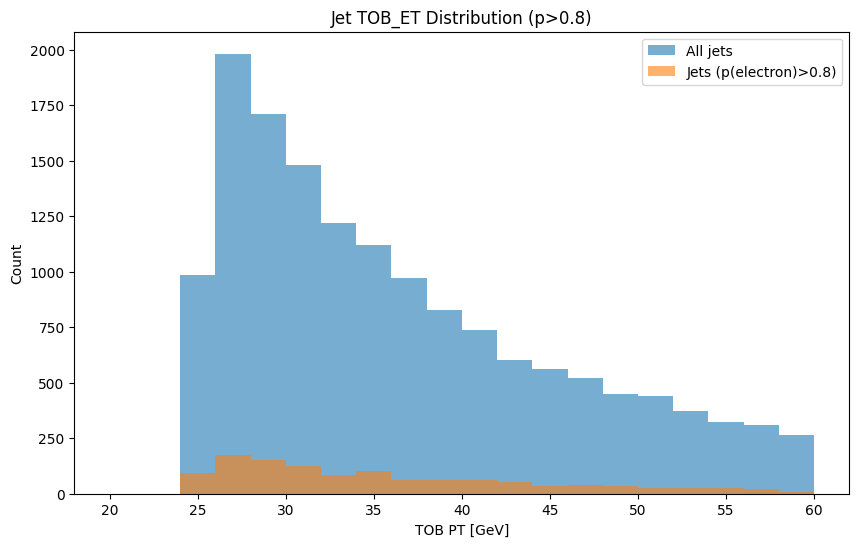

/tmp/ipykernel_63287/3875673871.py:69: RuntimeWarning: invalid value encountered in divide
  jets_survival = np.divide(


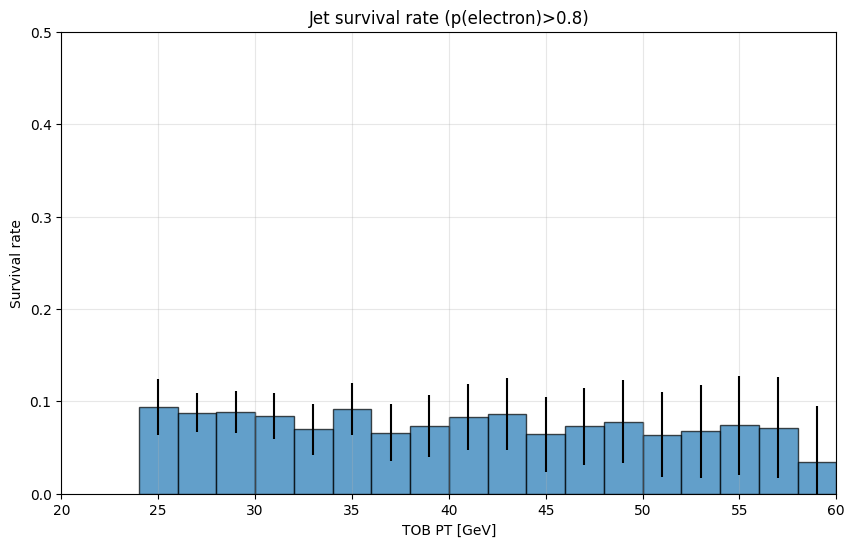

{0.0: {'efficiency': array([0.00894855, 0.03344482, 0.21393035, 0.64830012, 0.80891174,
         0.83089312, 0.8226257 , 0.83908046, 0.86302112, 0.85990072,
         0.8485164 , 0.85875   , 0.85081585, 0.8778135 , 0.91735537,
         0.86666667, 0.8125    , 0.85714286, 0.9       , 0.95833333]),
  'error': array([0.04708628, 0.0402034 , 0.03126817, 0.0203054 , 0.01279622,
         0.01112642, 0.01112945, 0.00986661, 0.00861179, 0.00879061,
         0.00888013, 0.00939581, 0.01318614, 0.01982127, 0.02613453,
         0.0421637 , 0.0625    , 0.06388766, 0.07071068, 0.04166667]),
  'bins': array([20., 22., 24., 26., 28., 30., 32., 34., 36., 38., 40., 42., 44.,
         46., 48., 50., 52., 54., 56., 58., 60.]),
  'n_total': array([ 447.,  598.,  804.,  853., 1167., 1366., 1432., 1653., 1847.,
         1813., 1921., 1600.,  858.,  311.,  121.,   75.,   48.,   35.,
           20.,   24.]),
  'n_tagged': array([   4.,   20.,  172.,  553.,  944., 1135., 1178., 1387., 1594.,
         1559., 163

In [79]:
analyze_jet_suppression(X_test_fullPt)        # test it

## Do we understand why are efficiencies so poor? Especially for low probability cuts? 

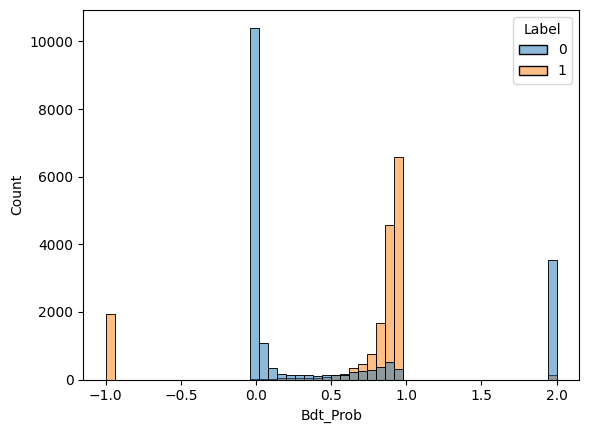

In [80]:
ax = sns.histplot(x='Bdt_Prob',
             data = X_test_fullPt,
             bins=50,
             hue='Label',
             hue_order=[0,1])
#ax.legend(["jet","electron"])
plt.show()

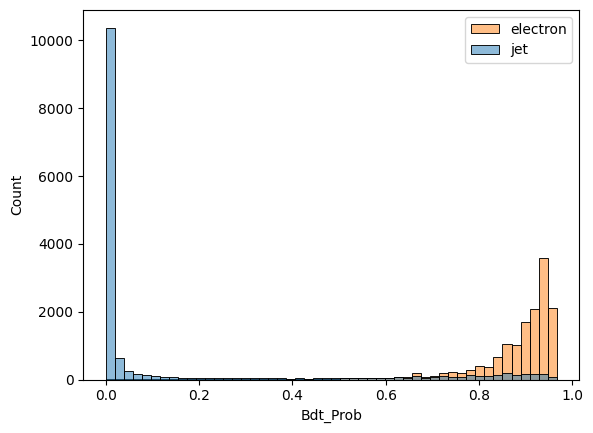

In [81]:
ax = sns.histplot(x='Bdt_Prob',
             data = X_test_fullPt.query("25 < TOB_ET < 60"),
             bins=50,
             hue='Label')
ax.legend(["electron","jet"])
plt.show()

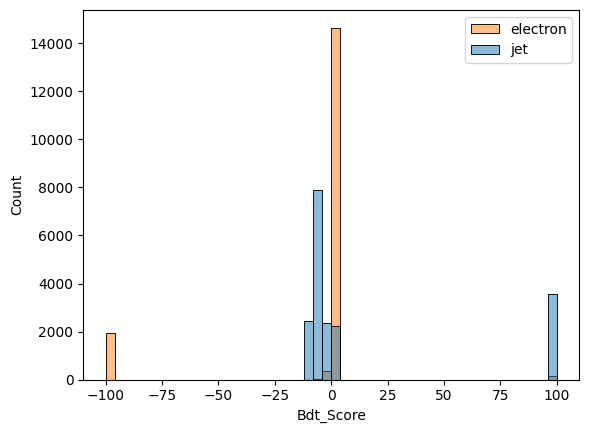

In [82]:
ax = sns.histplot(x='Bdt_Score',
             data = X_test_fullPt,
             bins=50,
             hue='Label')
ax.legend(["electron","jet"])
plt.show()

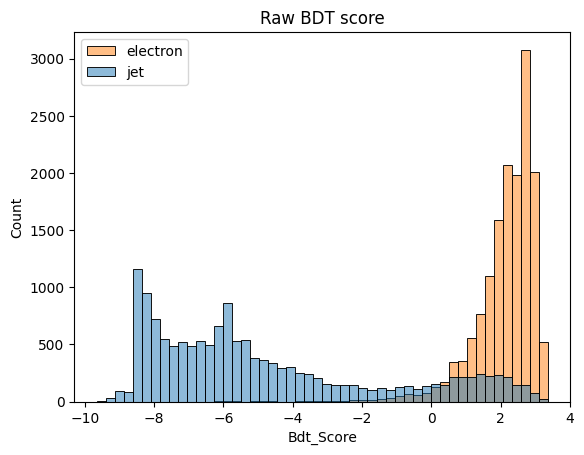

In [83]:
ax = sns.histplot(x='Bdt_Score',
             data = X_test_fullPt.query("25 < TOB_ET < 60"),
             bins=50,
             hue='Label')
ax.set(title="Raw BDT score")
ax.legend(["electron","jet"])
plt.savefig("RAW_BDT_score.png")
plt.show()

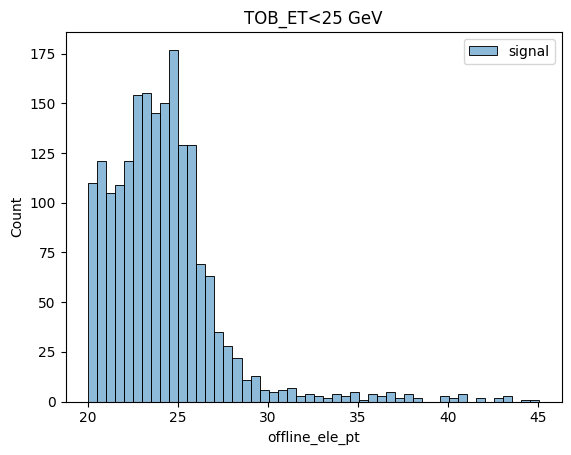

In [84]:
ax = sns.histplot(x='offline_ele_pt',
             data = X_test_fullPt.query("TOB_ET < 25"),
             bins=50,
             hue='Label')
ax.set(title="TOB_ET<25 GeV")
ax.legend(["signal","background"])
plt.savefig("Offline_Et_TOBcut.png")
plt.show()

### OK, this is starting to make sense, very poor resolution!

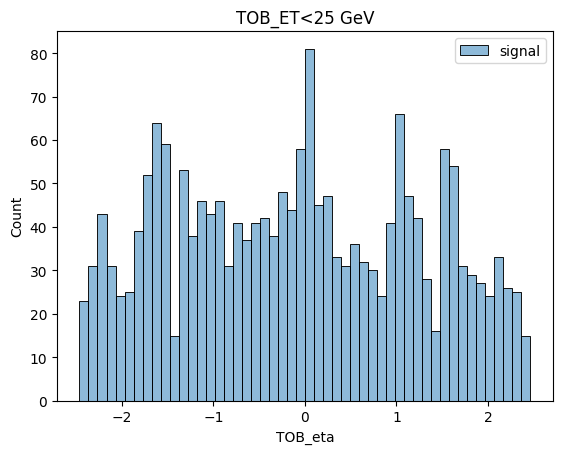

In [85]:
ax = sns.histplot(x='TOB_eta',
             data = X_test_fullPt.query("TOB_ET < 25"),
             bins=50,
             hue='Label')
ax.set(title="TOB_ET<25 GeV")
ax.legend(["signal","background"])

plt.show()

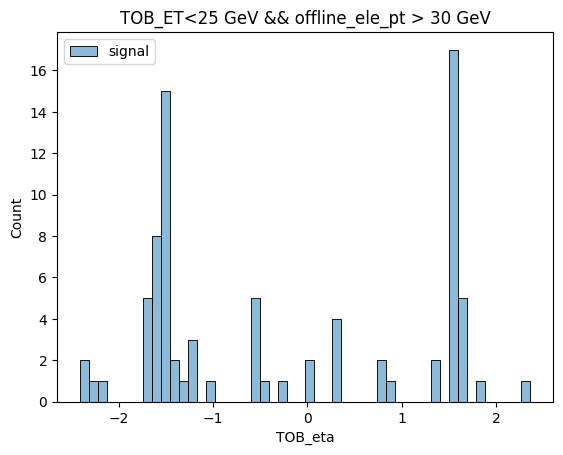

In [86]:
ax = sns.histplot(x='TOB_eta',
             data = X_test_fullPt.query("TOB_ET < 25 & offline_ele_pt > 30"),
             bins=50,
             hue='Label')
ax.set(title="TOB_ET<25 GeV && offline_ele_pt > 30 GeV")
ax.legend(["signal","background"])
plt.savefig("Offline_eta_TOB_ecut.png")
plt.show()

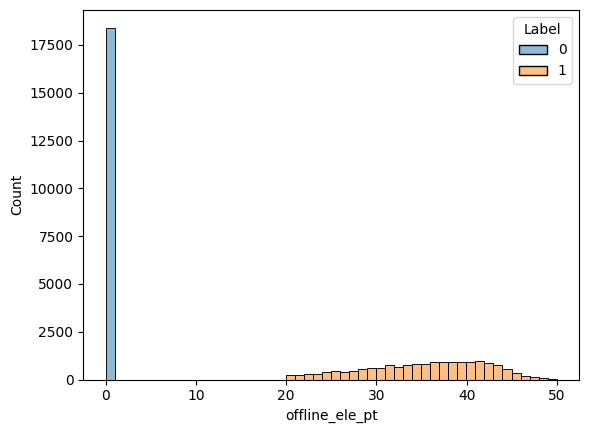

In [87]:
ax = sns.histplot(x='offline_ele_pt',
             data = X_test_fullPt.query("offline_ele_pt<50"),
             bins=50,
             hue='Label')
plt.show()

## Comparison between ROC and turn on curves, do they fit? 

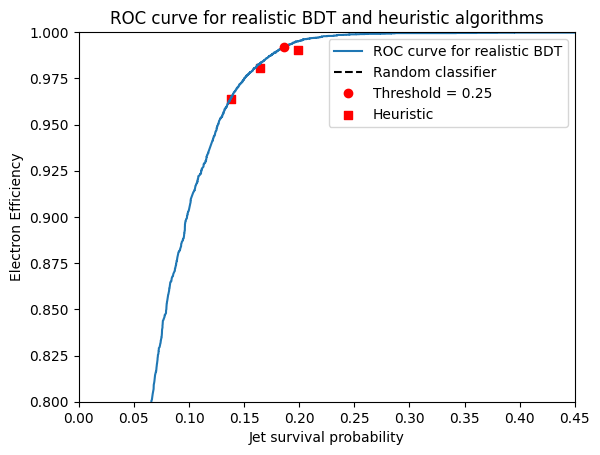

In [88]:
fpr_fw, tpr_fw, thresholds_fw = roc_curve(y_test_midPt, probs_bdt_fw[:,1])

# Plot the ROC curve
plt.figure()

#Find the index of the threshold closest to 0.5 (or desired threshold)
threshold = 0.25
thresh_idx = np.argmin(np.abs(thresholds_fw - threshold))

# Get the corresponding FPR and TPR values
fpr_point = fpr_fw[thresh_idx]
tpr_point = tpr_fw[thresh_idx]

plt.plot(fpr_fw, tpr_fw, label='ROC curve for realistic BDT')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')

# Add the point at threshold value
plt.plot(fpr_point, tpr_point, 'ro', label=f'Threshold = {threshold}')  # 'ro' means red dot

# adjust axes
plt.xlim(0., 0.45)
plt.ylim(0.8,1.0)

plt.xlabel('Jet survival probability')
plt.ylabel('Electron Efficiency')
plt.title('ROC curve for realistic BDT and heuristic algorithms')

for i in range(1,4):
    plt.scatter(1.-rejection_rates_heuristic[i],id_efficiencies_heuristic[i], color='r', marker='s', label='Heuristic' if i == 1 else '')


plt.legend()
plt.savefig("roc_point.png")



In [89]:
X_test_fullPt.head()

,TOB_ET,TOB_eta,TOB_ieta,TOB_ietabin,TOB_phi,offline_ele_pt,offline_ele_eta,offline_ele_eta_cal,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD,ID,Label,Bdt_Prob,Bdt_Score,weight
5183,24.200001,-0.3625,-4,3,0.245437,26.528650,-0.394457,-0.360491,12.800,0.0,22.299999,0.0,0.000,8.450,3,1,-1.0,-100.0,NaN
71832,19.200001,1.0375,10,10,0.343612,21.545616,1.002083,1.031086,9.525,0.0,16.625000,0.0,0.650,4.325,3,1,-1.0,-100.0,NaN
65089,23.500000,0.1375,1,1,-2.797981,25.755001,0.135409,0.142702,16.225,0.0,21.799999,0.0,0.000,5.575,3,1,-1.0,-100.0,NaN
48298,21.900000,-2.1125,-22,21,-1.325359,23.458000,-2.117181,-2.124835,9.875,0.0,19.750000,0.0,1.225,9.875,3,1,-1.0,-100.0,NaN
27896,24.799999,1.5875,15,15,-1.325359,26.754662,1.592299,1.587835,13.350,0.0,22.799999,0.0,3.275,8.075,3,1,-1.0,-100.0,NaN


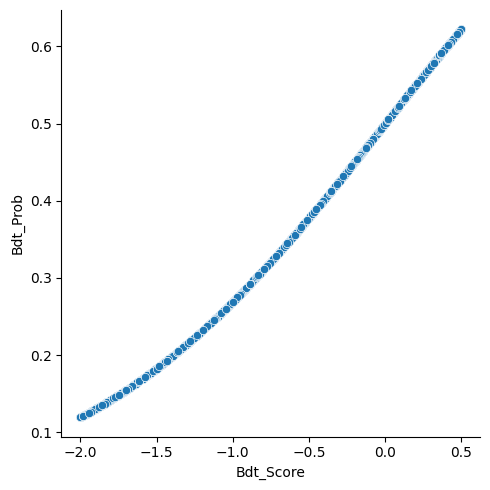

In [90]:
sns.relplot( x='Bdt_Score',
            y="Bdt_Prob",
            data=X_test_fullPt.query("-2<Bdt_Score<0.5"),
            kind="scatter")
plt.savefig("sigmoid.png")

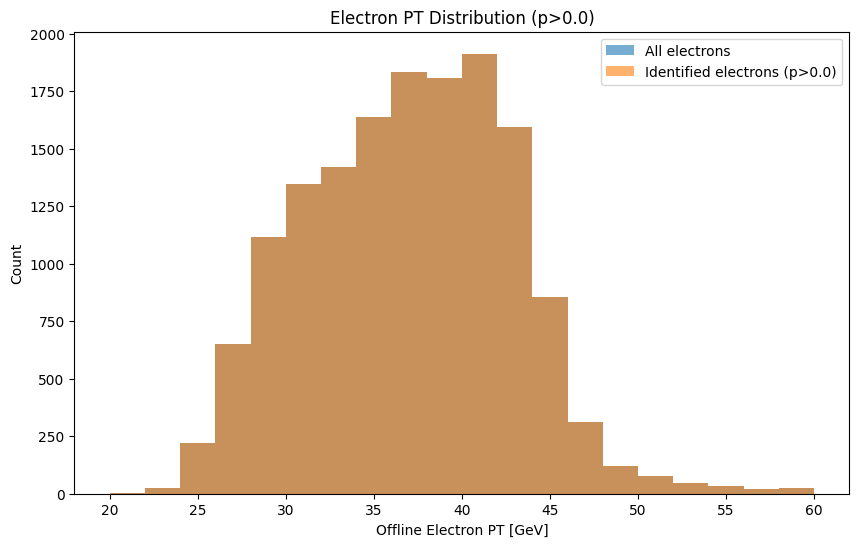

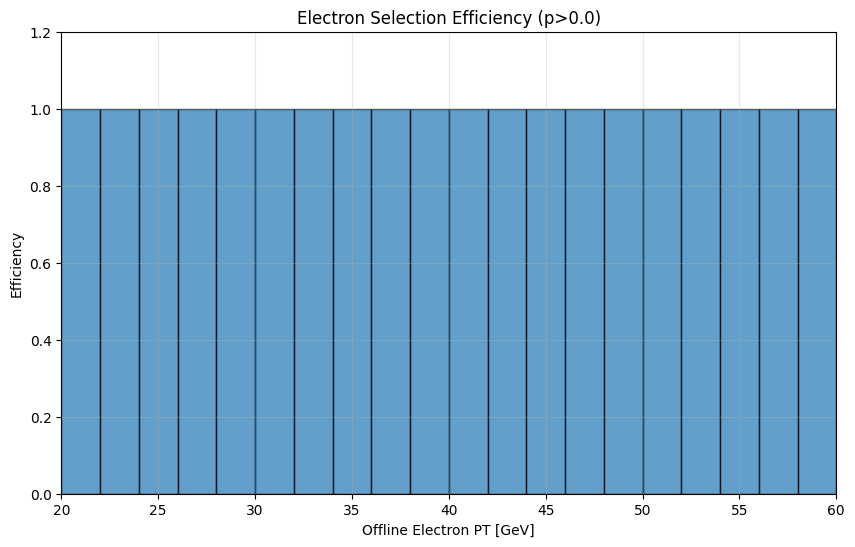

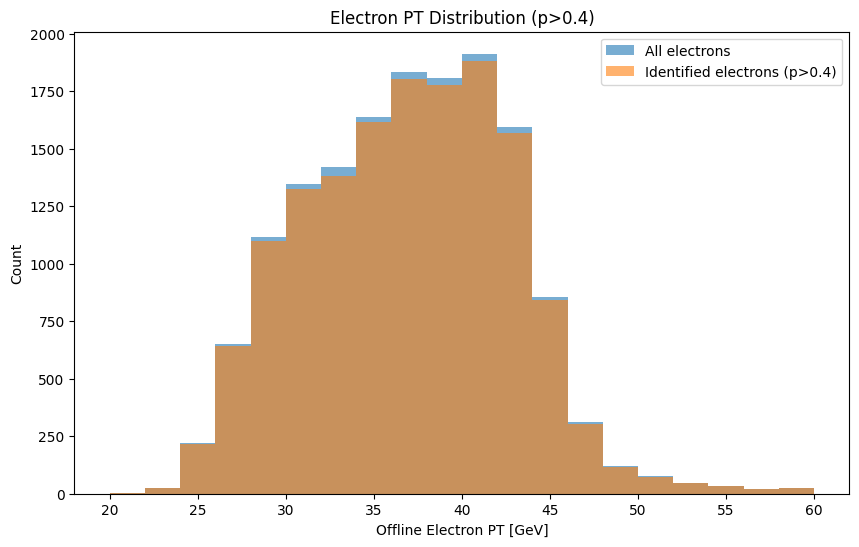

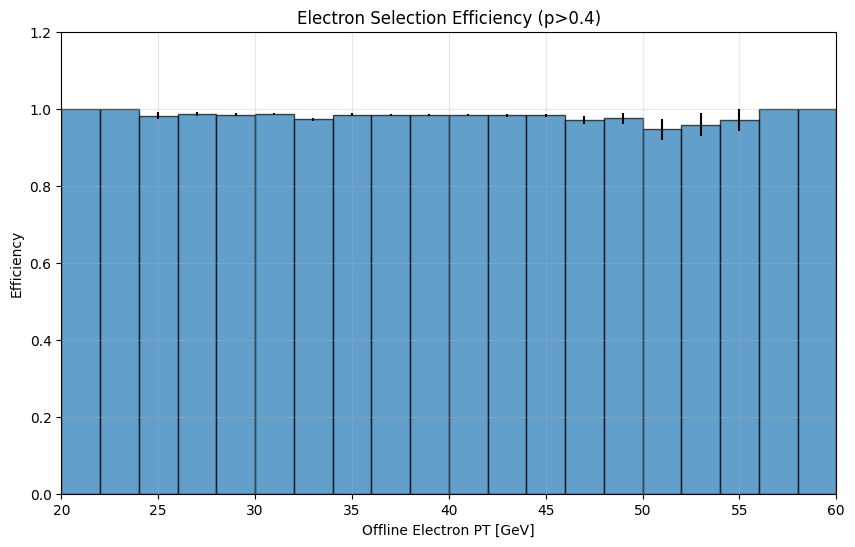

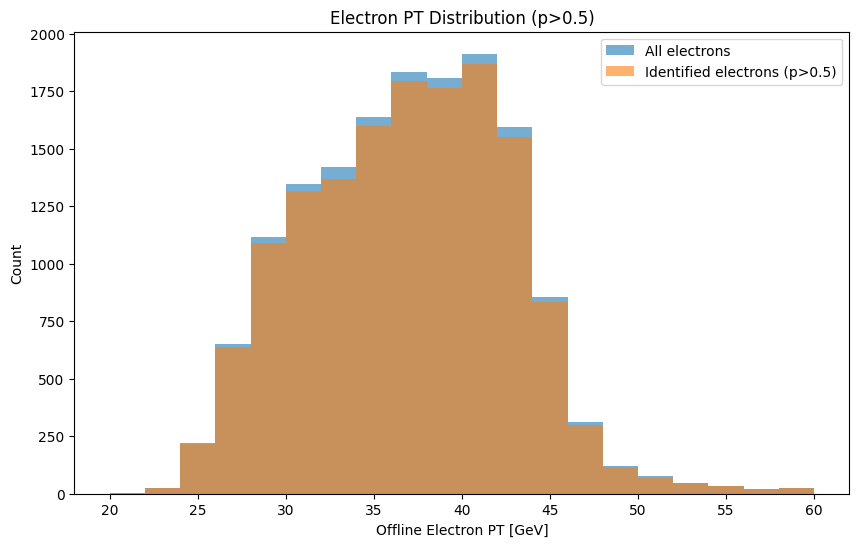

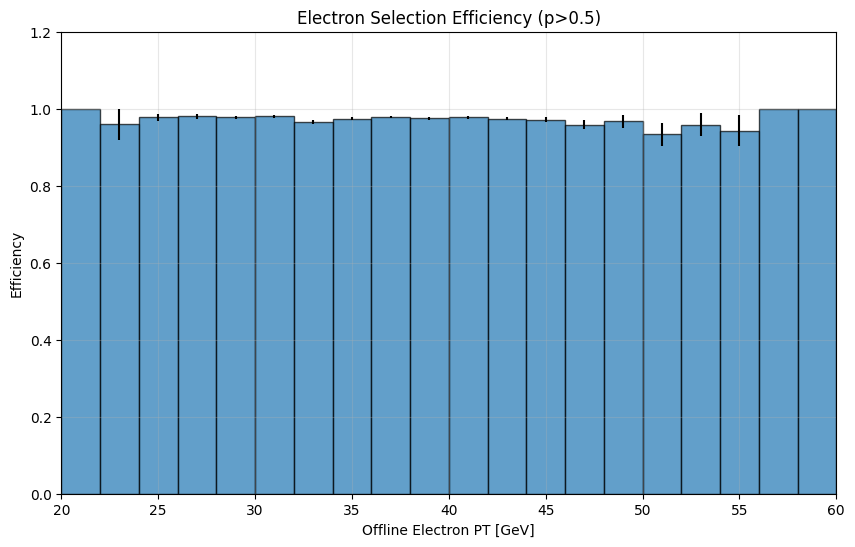

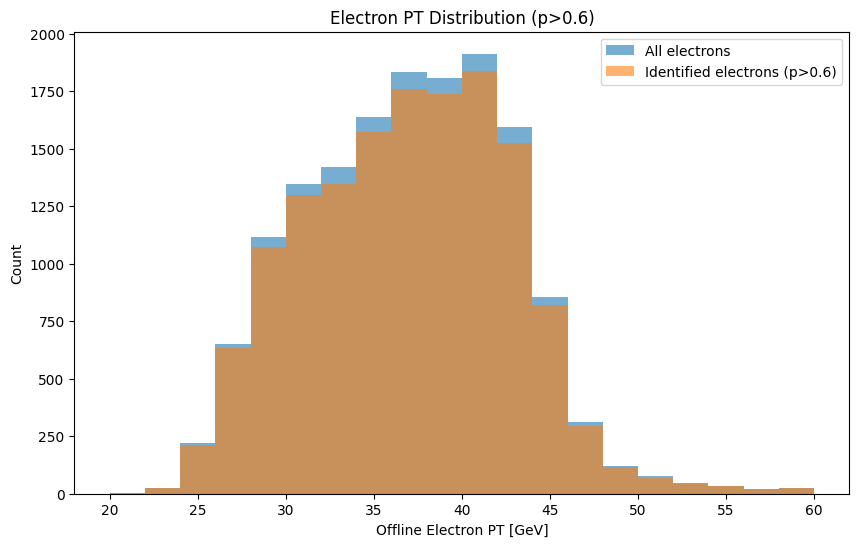

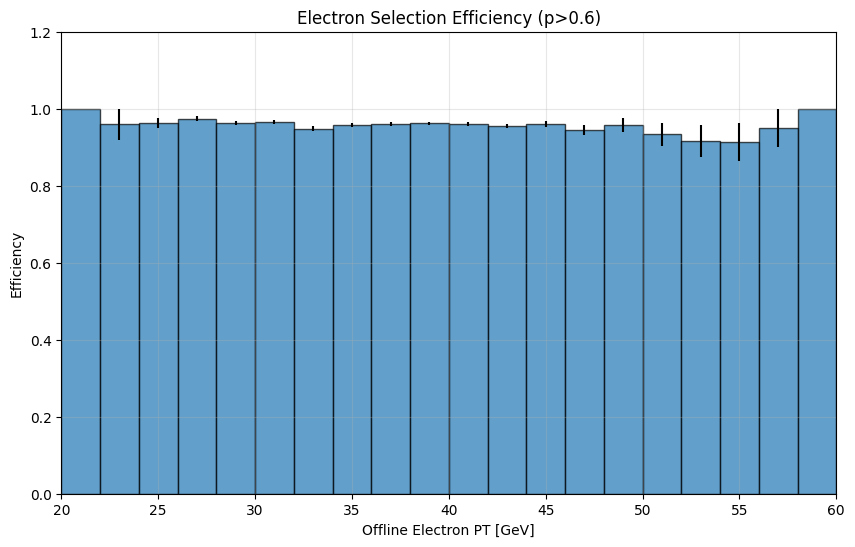

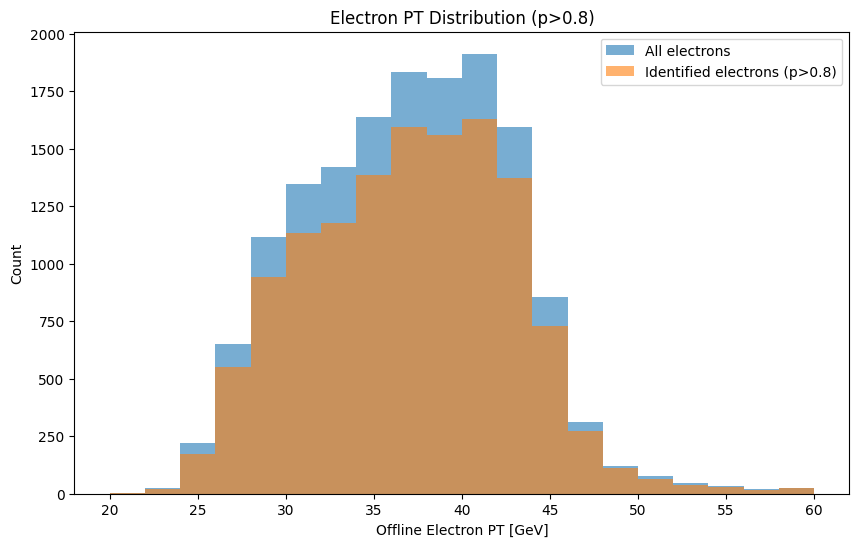

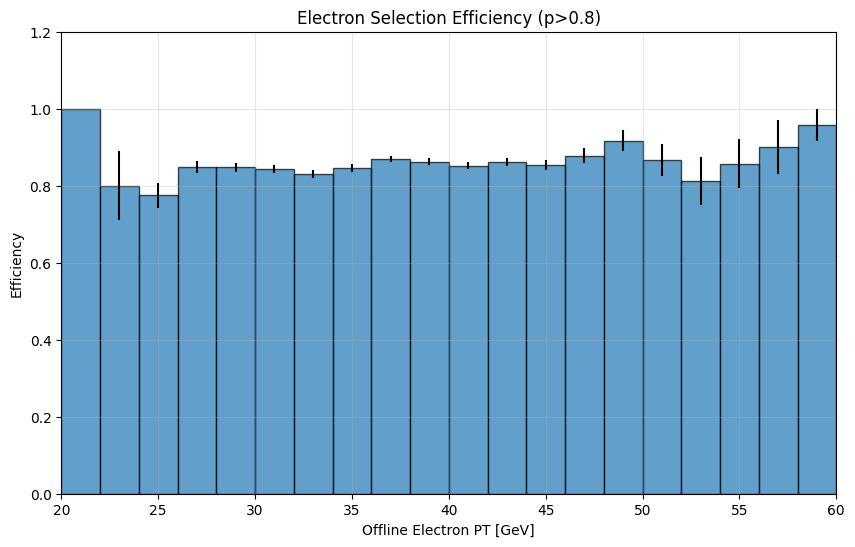

{0.0: {'efficiency': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.]),
  'error': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  'bins': array([20., 22., 24., 26., 28., 30., 32., 34., 36., 38., 40., 42., 44.,
         46., 48., 50., 52., 54., 56., 58., 60.]),
  'n_total': array([   4.,   25.,  222.,  652., 1114., 1345., 1419., 1640., 1833.,
         1808., 1913., 1595.,  856.,  311.,  121.,   75.,   48.,   35.,
           20.,   24.]),
  'n_tagged': array([   4.,   25.,  222.,  652., 1114., 1345., 1419., 1640., 1833.,
         1808., 1913., 1595.,  856.,  311.,  121.,   75.,   48.,   35.,
           20.,   24.])},
 0.4: {'efficiency': array([1.        , 1.        , 0.98198198, 0.98619632, 0.98473968,
         0.9866171 , 0.97251586, 0.9847561 , 0.98417894, 0.98396018,
         0.98431783, 0.98244514, 0.98247664, 0.97106109, 0.97520661,
         0.94666667, 0.95833333, 0.97142857, 1.    

In [91]:
analyze_electron_efficiency(X_test_fullPt.query("TOB_ET > 25"),save_dir="bdtOnly")    

## Analysis of the tree using SHAPS variables

In [92]:
import shap
shap.initjs()

In [93]:
X_test_midPt.head()

,eFEX_ReC,eFEX_ReE,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD
53012,27.200001,0.625,40.049999,0.0,0.950,11.650
157405,37.325001,8.825,57.349998,88.5,15.175,18.025
92064,17.174999,0.000,38.224998,0.0,4.150,9.200
69250,22.600000,0.000,37.450001,0.0,0.000,12.675
77596,17.650000,1.050,23.650000,0.0,0.000,6.000


In [94]:
shap_ex=shap.TreeExplainer(xgb_fw)
vals=shap_ex(X_test_midPt)

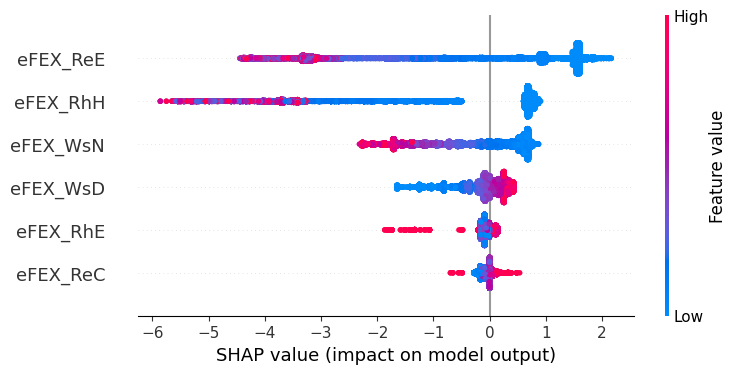

In [95]:
#fig = plt.figure(figsize=(8,4))
fig = plt.figure(figsize=(10,5))
shap.plots.beeswarm(vals)
#plt.savefig("shaps.png")

## Background sample

Zero-bias data for rate estimation

In [96]:
backgroundFileName="l1calo_hist_ZB.root"
File = uproot.open(backgroundFileName)
Tree = File["tree_DMC"]
DF_ZeroBias  = Tree.arrays(library="pd")
print (DF_ZeroBias.shape, DF_ZeroBias.columns)

(21761, 23) Index(['TOB_ET', 'TOB_eta', 'TOB_ieta', 'TOB_ietabin', 'TOB_phi',
       'offline_ele_pt', 'offline_ele_eta', 'offline_ele_eta_cal',
       'offline_ele_phi', 'offline_ele_phi_cal', 'eFEX_Clus_ETs', 'legacy_ET',
       'eFEX_ReC', 'eFEX_ReE', 'eFEX_RhE', 'eFEX_RhH', 'eFEX_WsN', 'eFEX_WsD',
       'ID', 'SuperCell_ET', 'lumiBlock', 'averageMu', 'BDTScore'],
      dtype='object')


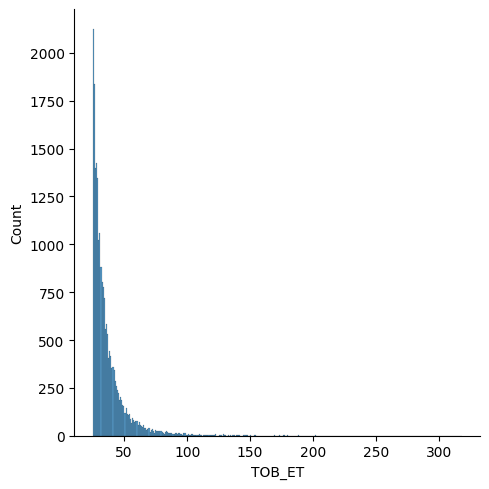

In [97]:
sns.displot(x="TOB_ET",
            data=DF_ZeroBias)

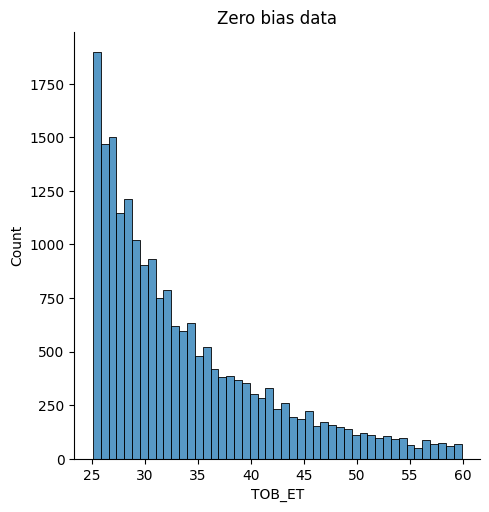

In [98]:
#plt.figure(figsize=(10, 5))
ax= sns.displot(x="TOB_ET",
            data=DF_ZeroBias.query("TOB_ET<60")
            #,kde=True
           )
ax.set(title="Zero bias data")
plt.savefig("TOB_ET_ZB_cut.png")
plt.show()

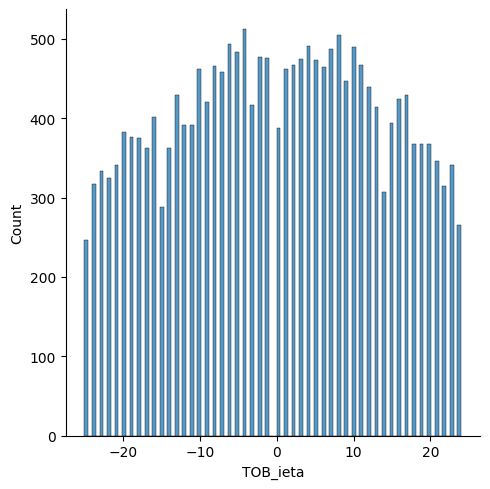

In [99]:
sns.displot(x="TOB_ieta",
            data=DF_ZeroBias.query("TOB_ET<60"),
            bins=100
           )

In [100]:
# cleaning for comparisons

In [101]:
DF_ZeroBias = DF_ZeroBias.query("TOB_ET<60")

In [102]:
ieta_bins_overlap=[-15,14]       # cut these eta bins out from the sample
DF_ZeroBias = DF_ZeroBias.query(" TOB_ieta not in @ieta_bins_overlap ")
DF_ZeroBias['Label'] = 0

In [103]:
DF_ZeroBias.head()

,TOB_ET,TOB_eta,TOB_ieta,TOB_ietabin,TOB_phi,offline_ele_pt,offline_ele_eta,offline_ele_eta_cal,offline_ele_phi,offline_ele_phi_cal,...,eFEX_RhE,eFEX_RhH,eFEX_WsN,eFEX_WsD,ID,SuperCell_ET,lumiBlock,averageMu,BDTScore,Label
0,29.900000,-1.2875,-13,12,0.736311,0.0,0.0,0.0,0.0,0.0,...,30.375000,8.0,0.675000,1.500,0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0...,231,63.609234,-6.671854,0
1,31.600000,-0.4375,-5,4,1.325359,0.0,0.0,0.0,0.0,0.0,...,32.724998,1.0,7.200000,3.775,0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0...,232,63.710388,-5.216143,0
2,41.900002,1.1875,11,11,0.834486,0.0,0.0,0.0,0.0,0.0,...,39.099998,21.0,27.424999,13.450,0,[0.0 0.0 0.0 0.0 2.200000047683716 2.099999904...,232,63.710388,-7.034279,0
3,41.299999,1.1375,11,11,0.932660,0.0,0.0,0.0,0.0,0.0,...,36.775002,21.0,12.925000,11.025,0,[0.0 2.200000047683716 2.0999999046325684 0.0 ...,232,63.710388,-7.034279,0
4,33.400002,-0.8625,-9,8,2.307107,0.0,0.0,0.0,0.0,0.0,...,28.950001,0.0,3.475000,6.700,3,[0.0 0.0 0.0 0.0 1.6749999523162842 0.0 0.0 0....,233,63.657265,-0.363816,0


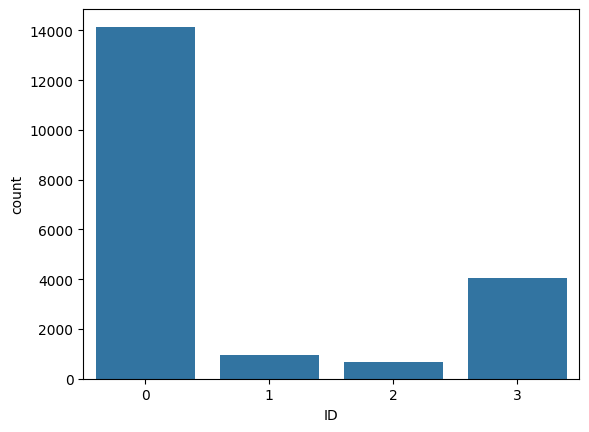

In [104]:
ax = sns.countplot(x='ID', 
#                   hue='Label', 
                   data=DF_ZeroBias,
#                   hue_order=[0, 1],  # Specify the order if needed
#                   palette='deep'    # Choose a color palette
                  )

In [105]:
id_efficiencies_heur_ZB,rejection_rates_heur_ZB,conf_matrices_heur_ZB = \
            analyseHeuristic(DF_ZeroBias)

In [106]:
print(id_efficiencies_heur_ZB,'\n',rejection_rates_heur_ZB)

[0.0, 0.0, 0.0, 0.0] 
 [0.0, 0.7152244237767893, 0.763040841083704, 0.7961484027496967]


In [107]:
1-np.array(rejection_rates_heur_ZB)

array([1.        , 0.28477558, 0.23695916, 0.2038516 ])

### Now BDT predictions for ZeroBias sample

In [108]:
X_test_ZB = DF_ZeroBias[trainingVariables]

In [109]:
predictions_bdt_fw_ZB = xgb_fw.predict(X_test_ZB)
probs_bdt_fw_ZB = xgb_fw.predict_proba(X_test_ZB)
bdt_score_fw_ZB = xgb_fw.predict(X_test_ZB,output_margin=True)

In [110]:
bdt_score_fw_ZB.shape

(19784,)

In [111]:
probs_bdt_fw_ZB.shape

(19784, 2)

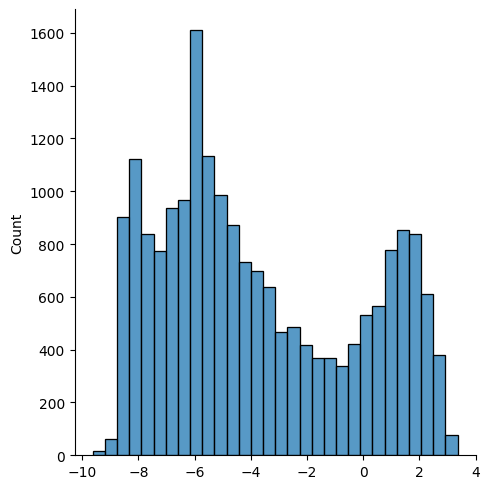

In [112]:
sns.displot(x=bdt_score_fw_ZB)

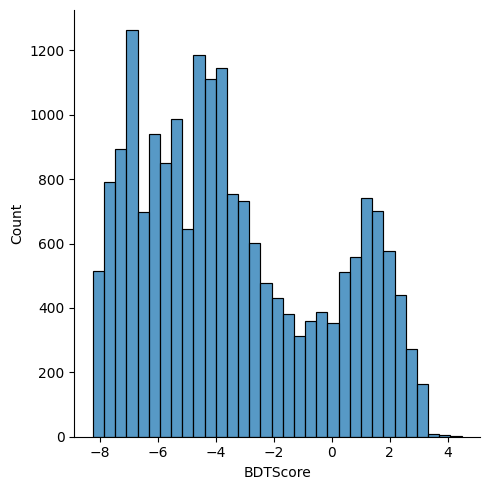

In [113]:
sns.displot(x="BDTScore",
            data=DF_ZeroBias)

In [114]:
def plot_probability_cutoff(probs):
    """
    Plots the fraction of events passing a given probability cutoff using Seaborn.
    
    Parameters:
    probs (pandas.Series): Series of probabilities
    """
    cutoffs = sorted(probs.unique(), reverse=True)
    fractions = []
    
    for cutoff in cutoffs:
        fraction = (probs >= cutoff).mean()
        fractions.append(fraction)
    
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=cutoffs, y=fractions)
    plt.xlabel("Probability Cutoff")
    plt.ylabel("Fraction of Events Passing Cutoff")
    plt.title("Probability Cutoff vs Fraction of Events")
    plt.grid()
    plt.show()

    return zip(cutoffs,fractions)


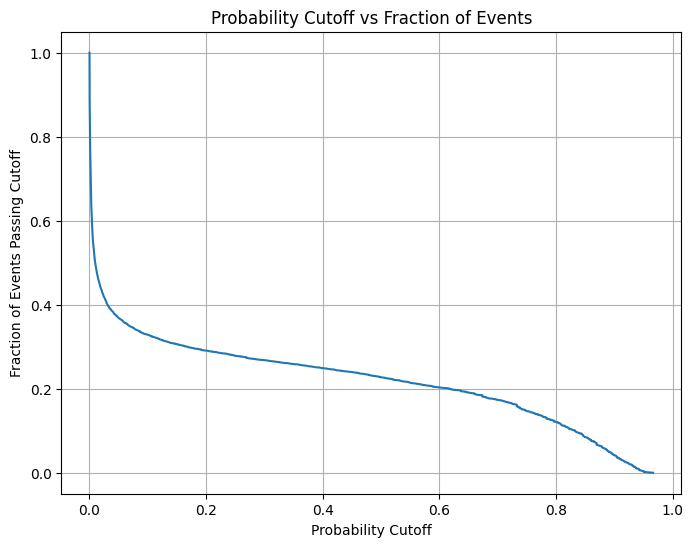

In [115]:
probs_all_zipped = plot_probability_cutoff(pd.Series(probs_bdt_fw_ZB[:,1]))

In [116]:
#for i,j in probs_all_zipped:
#    print("pr={}  rj={}".format(i,j))